https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/writeups/evgeniia-grigoreva-private-lb-8th-solution Market averages: Averages per date_id and time_id.
Rolling statistics: Rolling averages and standard deviations over the last 1000 time_ids for each symbol.
Besides that, I added time_id as a feature.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c hull-tactical-market-prediction
!unzip /content/hull-tactical-market-prediction.zip
!rm /content/hull-tactical-market-prediction.zip

Mounted at /content/drive
  0% 0.00/2.89M [00:00<?, ?B/s]
100% 2.89M/2.89M [00:00<00:00, 323MB/s]
Archive:  /content/hull-tactical-market-prediction.zip
  inflating: kaggle_evaluation/__init__.py  
  inflating: kaggle_evaluation/core/__init__.py  
  inflating: kaggle_evaluation/core/base_gateway.py  
  inflating: kaggle_evaluation/core/generated/__init__.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py  
  inflating: kaggle_evaluation/core/kaggle_evaluation.proto  
  inflating: kaggle_evaluation/core/relay.py  
  inflating: kaggle_evaluation/core/templates.py  
  inflating: kaggle_evaluation/default_gateway.py  
  inflating: kaggle_evaluation/default_inference_server.py  
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%%capture
# !pip install autogluon.tabular[all]

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest, f_regression
import random

# from autogluon.tabular import TabularDataset, TabularPredictor

## Load Data

M* - Market Dynamics/Technical features.
E* - Macro Economic features.
I* - Interest Rate features.
P* - Price/Valuation features.
V* - Volatility features.
S* - Sentiment features.
MOM* - Momentum features.
D* - Dummy/Binary features.

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
# sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train.iloc[:,:3].head(14)

,D1,D2,D3
date_id,,,
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0


In [ ]:
target = ['forward_returns', 'risk_free_rate',	'market_forward_excess_returns']
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()[:-4]
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [ ]:
train.shape, test.shape

((8990, 97), (10, 98))

In [ ]:
train.iloc[:,:4].head(14)

,D1,D2,D3,D4
date_id,,,,
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,0,1
6,0,0,0,1
7,0,0,0,1
8,0,0,0,1


## EDA

### Missing Values Check

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column not in target:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len( unique_test_values - unique_train_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    else:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,D1,int64,0.0,0.0,0.0002,2,1,0.0
1,D2,int64,0.0,0.0,0.0002,2,1,0.0
2,D3,int64,0.0,0.0,0.0002,2,2,0.0
3,D4,int64,0.0,0.0,0.0002,2,1,0.0
4,D5,int64,0.0,0.0,0.0002,2,2,0.0
...,...,...,...,...,...,...,...,...
92,V8,float64,11.2,0.0,0.2544,2287,10,0.0
93,V9,float64,50.5,0.0,0.4951,4451,10,0.0
94,forward_returns,float64,0.0,NA,0.9913,8912,NA,NA
95,risk_free_rate,float64,0.0,NA,0.2143,1927,NA,NA


In [ ]:
df_summary.sort_values('Train Missing %', ascending = False)

,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
26,E7,float64,77.5,0.0,0.2248,2021,10,0.0
82,V10,float64,67.3,0.0,0.3271,2941,10,0.0
74,S3,float64,63.8,0.0,0.3623,3257,10,0.0
38,M1,float64,61.7,0.0,0.3830,3443,10,0.0
42,M13,float64,61.6,0.0,0.3838,3450,10,0.0
...,...,...,...,...,...,...,...,...
5,D6,int64,0.0,0.0,0.0002,2,1,0.0
4,D5,int64,0.0,0.0,0.0002,2,2,0.0
94,forward_returns,float64,0.0,NA,0.9913,8912,NA,NA
95,risk_free_rate,float64,0.0,NA,0.2143,1927,NA,NA


### Plots

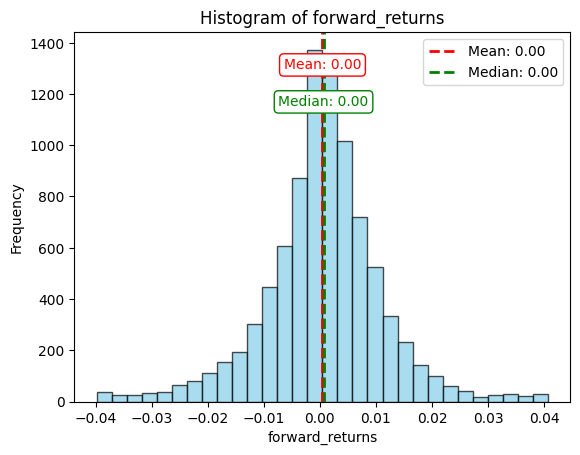

In [ ]:
target = 'forward_returns'

# Histogram for continuous target
plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

# Calculate mean and median
mean_value = np.mean(train[target])
median_value = np.median(train[target])

# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Add text annotations
plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

# Labels and title
plt.xlabel(target)
plt.ylabel("Frequency")
plt.title(f"Histogram of {target}")
plt.legend()

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7e0b95d9fe20> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7e0b8480d9e0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
target = 'forward_returns'
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each numeric column and plot the scatter plot
for i, col in enumerate(numeric_cols):
    axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
    axs[i].set_title(f"{col} vs {target}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel(target)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
target = 'forward_returns'
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    ax1 = axs[i]

    # First y-axis for feature column
    ax1.plot(train.index, train[col], color='tab:blue', label=col)
    ax1.set_xlabel('Index')
    ax1.set_ylabel(col, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Second y-axis for target
    ax2 = ax1.twinx()
    ax2.plot(train.index, train[target], color='tab:red', alpha=0.6, label=target)
    ax2.set_ylabel(target, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Title
    ax1.set_title(f"{col} and {target} over index")

    # Optional: align legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
corr = train[numeric_cols + [target]].corr()
plt.figure(figsize = (10, 8), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
plt.show()

In [ ]:
corr[target].sort_values()

In [ ]:
train["day_of_week"] = train.index % 5
train['month_of_year'] = (train.index // 20) % 12

In [ ]:
plt.figure(figsize=(8, 5))
train.boxplot(column="market_forward_excess_returns", by="month_of_year")
plt.title("Market Forward Excess Returns by month_of_year")
plt.suptitle("")  # removes default Pandas subtitle
plt.xlabel("month_of_year")
plt.ylabel("Market Forward Excess Returns")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
train.boxplot(column="market_forward_excess_returns", by="day_of_week")
plt.title("Market Forward Excess Returns by Day of Week")
plt.suptitle("")  # removes default Pandas subtitle
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Market Forward Excess Returns")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Scoring Function

In [ ]:
import pandas.api.types
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    if market_volatility == 0:
        raise ParticipantVisibleError('Division by zero, market std is zero')

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

In [ ]:
def score2(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    if market_volatility == 0:
        raise ParticipantVisibleError('Division by zero, market std is zero')

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

## Linear Regression Models

1. alternate ret strategies - done, revisit nonlinear later
2. Feature engineering (lags, rolling stats, momentum, interaction terms, vol-adjusted features).
3. Feature selection
4. Walk-forward (time-series) CV + metric that penalizes excess volatility beyond 120% of market.
5. Smaller data window

In [ ]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
# Config
# ============ PATHS ============
DATA_PATH: Path = Path('/content/')

# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = 400.0                # Multiplier of the OLS market forward excess returns predictions to signal

# ============ MODEL CONFIGS ============
CV: int = 10                                    # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5                           # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(-4, 2, 100)    # Constant that multiplies the penalty terms
MAX_ITER: int = 1000000                         # The maximum number of iterations

In [ ]:
@dataclass
class DatasetOutput:
    X_train : pl.DataFrame
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass
class ElasticNetParameters:
    l1_ratio : float
    cv: int
    alphas: np.ndarray
    max_iter: int

    def __post_init__(self):
        if self.l1_ratio < 0 or self.l1_ratio > 1:
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

In [ ]:
# Set Parameters
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO,
    cv = CV,
    alphas = ALPHAS,
    max_iter = MAX_ITER
)

In [ ]:
# Helper Functions
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "train.csv")
        .rename({'market_forward_excess_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        ).with_columns(
        (pl.col("date_id") % 5).alias("day_of_week")
    ).with_columns(((pl.col("date_id") // 20) % 12).alias("month")).head(-10)
    )

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
            pl.exclude('date_id').cast(pl.Float64, strict=False)
        ).with_columns(
        (pl.col("date_id") % 5).alias("day_of_week")
    )
    )

def create_example_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """
    Creates new features and cleans a DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The DataFrame with new features, selected columns, and no null values.
    """
    vars_to_keep = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13", "U1", "U2"
    ]

    return (
        df.with_columns(
            (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2")
        )
        .select(["date_id", "target"] + vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in vars_to_keep
        ])
        .drop_nulls()
    )

def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]

    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical")

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput:
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model.

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.drop(['date_id','target'])
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target'])
    y_test = test.get_column('target')

    scaler = StandardScaler() #MinMaxScaler() #StandardScaler()

    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)

    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)


    return DatasetOutput(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        scaler = scaler
    )

In [ ]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
    )

def zscore_ret_to_signal(ret_arr, lookback=100, clip_range=(0, 2)):
    mean = np.mean(ret_arr[-lookback:])
    std = np.std(ret_arr[-lookback:])
    zscores = (ret_arr - mean) / (std + 1e-8)
    return np.clip(1 + zscores * 0.2, *clip_range)

def quantile_signal(ret_arr, n_quantiles=5, clip_range=(0, 2)):
    ranks = pd.qcut(ret_arr, n_quantiles, labels=False, duplicates='drop')
    return np.clip(1 + (ranks - n_quantiles//2) / (n_quantiles//2), *clip_range)

def vol_adjusted_signal(ret_arr, vol_arr, target_vol=0.02, clip_range=(0, 2)):
    adj_signal = 1 + (ret_arr / (vol_arr + 1e-8)) * target_vol
    return np.clip(adj_signal, *clip_range)

def nonlinear_signal(ret_arr, scale=5.0, clip_range=(0, 2)):
    signal = 1 + np.tanh(scale * ret_arr)
    return np.clip(signal, *clip_range)

def threshold_signal(ret_arr, pos_thresh=0.01, neg_thresh=-0.01):
    signal = np.where(ret_arr > pos_thresh, 2, np.where(ret_arr < neg_thresh, 0, 1))
    return signal

In [ ]:
train = load_trainset()
test = load_testset()

market_cols = ['M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
macro_cols = ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']
rate_cols = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
price_cols = ['P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
vol_cols = ['V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
sent_cols = ['S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
# mom_cols = [c for c in df.columns if c.startswith("MOM")]
dummy_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

df = join_train_test_dataframes(train, test)

In [ ]:
# Feat engineer
def std_horizontal(cols: list[str]) -> pl.Expr:
    mean = pl.mean_horizontal(cols)
    return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())

df = df.with_columns([
    # Mean and standard deviation across M features
    pl.mean_horizontal(market_cols).alias("M_mean"),
    std_horizontal(market_cols).alias("M_std"),
    # Normalized versions (z-scores)
    *[
        ((pl.col(c) - pl.mean_horizontal(market_cols)) / std_horizontal(market_cols)).alias(f"{c}_z")
        for c in market_cols
    ],
])

# Momentum
df = df.with_columns([
    pl.mean_horizontal(macro_cols).alias("E_composite"),
    (pl.max_horizontal(macro_cols) - pl.min_horizontal(macro_cols)).alias("E_range"),
])

for c in macro_cols:
    df = df.with_columns(
        (pl.col(c) - pl.col(c).shift(5)).alias(f"{c}_5d_change")
    )

# Interest Rates
df = df.with_columns([
    pl.mean_horizontal(rate_cols).alias("I_avg_yield"),
    (pl.col("I1") - pl.col("I9")).alias("I_yield_spread"),  # short vs long
    (pl.col("I1") - pl.col("I1").shift(5)).alias("I_short_rate_change_5d"),
])

# Price Valuation
df = df.with_columns([
    pl.mean_horizontal(price_cols).alias("P_mean"),
    (pl.max_horizontal(price_cols) / (pl.min_horizontal(price_cols) + 1e-9)).alias("P_ratio_range"),
])

for c in price_cols:
    df = df.with_columns([
        (pl.col(c) - pl.col(c).shift(10)).alias(f"{c}_10d_momentum"),
    ])

# Add vol (Lose a lot of rows)
df = df.with_columns([
    pl.mean_horizontal(vol_cols).alias("V_mean"),
    std_horizontal(vol_cols).alias("V_std"),
    *[
        (pl.col(col).abs() + 1e-6).log1p().fill_nan(0).alias(f"{col}_log_vol")
        for col in vol_cols
    ],
])

# Add Sent
df = df.with_columns([
    pl.mean_horizontal(sent_cols).alias("S_mean"),
    pl.max_horizontal(sent_cols).alias("S_max"),
    (pl.col("S1") - pl.col("S1").shift(3)).alias("S1_3d_delta"),
])

# Dummy
df = df.with_columns([
    pl.sum_horizontal(dummy_cols).alias("D_sum_active"),
])
df = df.with_columns([
    # (pl.col("M_mean") + pl.col("MOM_mean") - pl.col("V_mean")).alias("risk_adjusted_momentum"),
    (pl.col("S_mean") * pl.col("E_composite")).alias("macro_sentiment_signal"),
])

df.shape, df.drop_nulls().shape

((8990, 177), (2016, 177))

In [ ]:
# df.select([
#     pl.col(c).is_null().sum().alias(c)
#     for c in df.columns
# ])

In [ ]:
df = df.with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls()

# df = df.with_columns([
#     pl.col(c).fill_null(0).alias(c)
#     for c in df.columns
# ]).drop_nulls()
# df = create_example_dataset(df=df)





# Train test split
train = df.filter(pl.col('date_id').is_in(train.get_column('date_id')))
test = df.filter(pl.col('date_id').is_in(test.get_column('date_id')))

FEATURES = [col for col in test.columns if col not in ['date_id', 'target']]
# feats = ['E16',
#  'E17',
#  'E18',
#  'E2',
#  'I5',
#  'I8',
#  'M11',
#  'M14',
#  'P11',
#  'P2',
#  'P6',
#  'P8',
#  'V13',
#  'V7',
#  'V9']

dataset = split_dataset(train=train, test=test, features=FEATURES)

X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test
scaler = dataset.scaler

df.shape

(2021, 97)

In [ ]:
model = LinearRegression()
# model = ElasticNetCV(**asdict(enet_params)) #
model.fit(X_train, y_train)

LinearRegression()

Base lin reg
Train RMSE: 0.0111
Test RMSE:  0.0053
Train R²:   0.0057
Test R²:    -0.0491

all feats lin reg: Train RMSE: 0.0103
Test RMSE:  0.0050
Train R²:   0.0921
Test R²:    0.0648

all feats er: Train RMSE: 0.0107
Test RMSE:  0.0053
Train R²:   0.0183
Test R²:    -0.0298

train rfe: Train RMSE: 0.0105
Test RMSE:  0.0056
Train R²:   0.0529
Test R²:    -0.1610

train er rfe: Train RMSE: 0.0104
Test RMSE:  0.0053
Train R²:   0.0430
Test R²:    -0.0492

*RFE not good

train LR all feats + date feats Train RMSE: 0.0103
Test RMSE:  0.0062
Train R²:   0.0923
Test R²:    -0.4169

same fillna 0 Train RMSE: 0.0104
Test RMSE:  0.0054
Train R²:   0.0249
Test R²:    -0.0874

added m: Train RMSE: 0.0103
Test RMSE:  0.0059
Train R²:   0.1046
Test R²:    -0.2768

added e: Train RMSE: 0.0103
Test RMSE:  0.0059
Train R²:   0.1046
Test R²:    -0.2830

all feat eng: Train RMSE: 0.0094
Test RMSE:  0.0068
Train R²:   0.1913
Test R²:    -0.6936

In [ ]:
# # model = LinearRegression()
# model = ElasticNetCV(**asdict(enet_params))
# selector = RFE(model, n_features_to_select=15)
# X_train_selected = selector.fit_transform(X_train, y_train)
# X_test_selected = selector.transform(X_test)

In [ ]:
# selected_features = selector.get_feature_names_out()
# selected_features = selected_features.tolist()
# X_train_sel = pl.DataFrame(selector.transform(X_train.to_numpy()), schema=selected_features)
# X_test_sel = pl.DataFrame(selector.transform(X_test.to_numpy()), schema=selected_features)

# # Fit model using selected features
# model.fit(X_train_selected, y_train)


Train RMSE: 0.0103
Test RMSE:  0.0062
Train R²:   0.0923
Test R²:    -0.4169


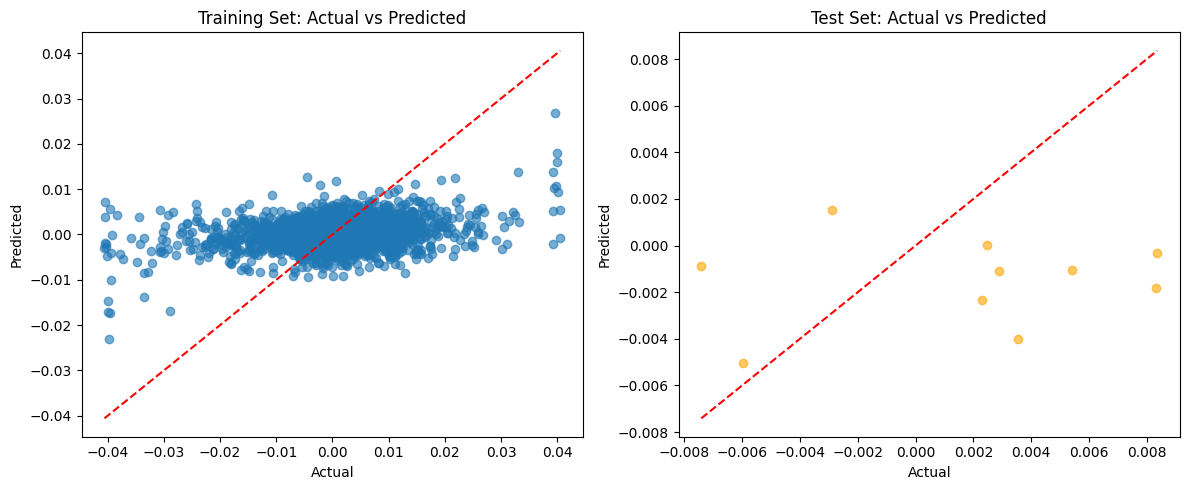

In [ ]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

# Training performance
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')

# Test performance
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='orange')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.tight_layout()
plt.show()

        feature  coefficient  abs_coef
20           E2     0.018848  0.018848
58          P11    -0.016573  0.016573
61           P2     0.011727  0.011727
82          V10    -0.011133  0.011133
86           V2    -0.010671  0.010671
162  V2_log_vol     0.010444  0.010444
17          E17    -0.010063  0.010063
38           M1     0.008579  0.008579
168  V8_log_vol     0.008038  0.008038
40          M11    -0.007413  0.007413


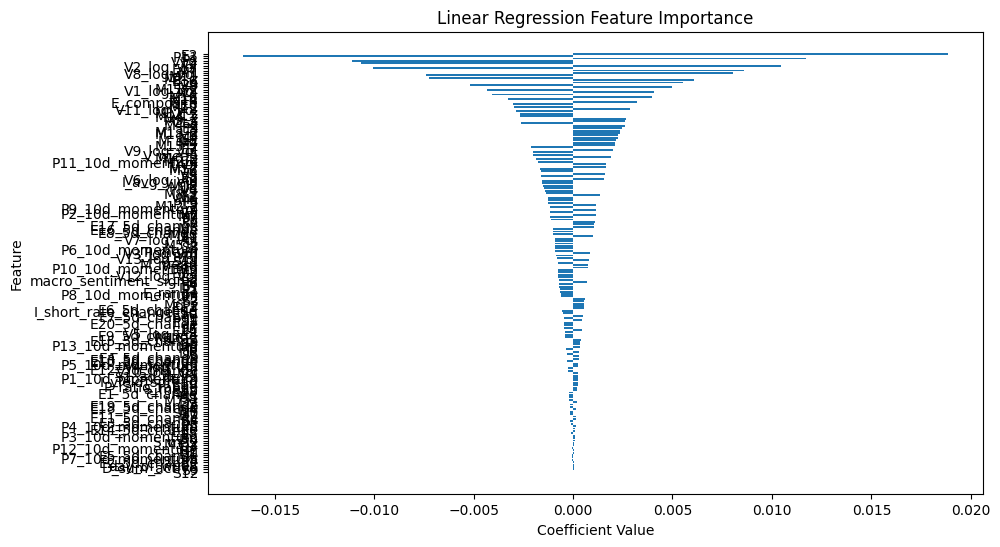

In [ ]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_
})

# Sort by absolute magnitude of coefficients
importance["abs_coef"] = importance["coefficient"].abs()
importance = importance.sort_values("abs_coef", ascending=False)

# Display top features
print(importance.head(10))

# Optional: Plot
plt.figure(figsize=(10, 6))
plt.barh(importance["feature"], importance["coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Linear Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
solution = load_trainset().with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls().to_pandas()

solution['prediction'] = convert_ret_to_signal(y_train_pred, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

2.2165875132731583

In [ ]:
# def predict(test: pl.DataFrame) -> float:
#     test = test.rename({'lagged_forward_returns':'target'})
#     df: pl.DataFrame = create_example_dataset(test)
#     X_test: pl.DataFrame = df.select(FEATURES)
#     X_test_scaled_np: np.ndarray = scaler.transform(X_test)
#     X_test: pl.DataFrame = pl.from_numpy(X_test_scaled_np, schema=FEATURES)
#     raw_pred: float = model.predict(X_test)[0]
#     return convert_ret_to_signal(raw_pred, ret_signal_params)

# inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

# if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#     inference_server.serve()
# else:
#     inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))

## Histogram Gradient Boosting Models
1. alternate ret strategies - done, revisit nonlinear later
2. Feature engineering (lags, rolling stats, momentum, interaction terms, vol-adjusted features).
2a. Add Cyclic Date with sin and cos
3. Feature selection
4. Walk-forward (time-series) CV + metric that penalizes excess volatility beyond 120% of market.
5. Smaller data window
6. Optimize for R2 more priority, create CV metric

In [ ]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor

# Config
# ============ PATHS ============
DATA_PATH: Path = Path('/content/')

# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = 400.0                # Multiplier of the OLS market forward excess returns predictions to signal

# ============ MODEL CONFIGS ============
CV: int = 10                                    # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5                           # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(-4, 2, 100)    # Constant that multiplies the penalty terms
MAX_ITER: int = 1000000                         # The maximum number of iterations


@dataclass
class DatasetOutput:
    X_train : pl.DataFrame
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass
class ElasticNetParameters:
    l1_ratio : float
    cv: int
    alphas: np.ndarray
    max_iter: int

    def __post_init__(self):
        if self.l1_ratio < 0 or self.l1_ratio > 1:
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL


# Set Parameters
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO,
    cv = CV,
    alphas = ALPHAS,
    max_iter = MAX_ITER
)

In [ ]:
# Helper Functions
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """

    return (
    pl.read_csv(DATA_PATH / "train.csv")
    .rename({"market_forward_excess_returns": "target"})
    .with_columns(
        pl.exclude("date_id").cast(pl.Float64, strict=False)
    )
    .with_columns(
        (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2"),
        (pl.col("date_id") % 5).alias("day_of_week"),
        ((pl.col("date_id") // 20) % 12).alias("month")
    )
    .with_columns([
        # Cyclic encoding for day_of_week (period = 5)
        (pl.col("day_of_week") * (2 * np.pi / 5)).sin().alias("day_of_week_sin"),
        (pl.col("day_of_week") * (2 * np.pi / 5)).cos().alias("day_of_week_cos"),

        # Cyclic encoding for month (period = 12)
        (pl.col("month") * (2 * np.pi / 12)).sin().alias("month_sin"),
        (pl.col("month") * (2 * np.pi / 12)).cos().alias("month_cos"),
    ])
    # .head(-10)
)

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
        pl.exclude("date_id").cast(pl.Float64, strict=False)
    )
    .with_columns(
        (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2"),
        (pl.col("date_id") % 5).alias("day_of_week"),
        ((pl.col("date_id") // 20) % 12).alias("month")
    )
    .with_columns([
        # Cyclic encoding for day_of_week (period = 5)
        (pl.col("day_of_week") * (2 * np.pi / 5)).sin().alias("day_of_week_sin"),
        (pl.col("day_of_week") * (2 * np.pi / 5)).cos().alias("day_of_week_cos"),

        # Cyclic encoding for month (period = 12)
        (pl.col("month") * (2 * np.pi / 12)).sin().alias("month_sin"),
        (pl.col("month") * (2 * np.pi / 12)).cos().alias("month_cos"),
    ])
    )

def create_example_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """
    Creates new features and cleans a DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The DataFrame with new features, selected columns, and no null values.
    """
    vars_to_keep = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13", "U1", "U2"
    ]

    return (
        df.with_columns(
            (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2")
        )
        .select(["date_id", "target"] + vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in vars_to_keep
        ])
        .drop_nulls()
    )

def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]

    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical")

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput:
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model.

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.drop(['date_id','target'])
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target'])
    y_test = test.get_column('target')

    scaler = StandardScaler() #MinMaxScaler() #StandardScaler()

    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)

    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)


    return DatasetOutput(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        scaler = scaler
    )

In [ ]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
    )

def zscore_ret_to_signal(ret_arr, lookback=100, clip_range=(0, 2)):
    mean = np.mean(ret_arr[-lookback:])
    std = np.std(ret_arr[-lookback:])
    zscores = (ret_arr - mean) / (std + 1e-8)
    return np.clip(1 + zscores * 0.2, *clip_range)

def quantile_signal(ret_arr, n_quantiles=5, clip_range=(0, 2)):
    ranks = pd.qcut(ret_arr, n_quantiles, labels=False, duplicates='drop')
    return np.clip(1 + (ranks - n_quantiles//2) / (n_quantiles//2), *clip_range)

def vol_adjusted_signal(ret_arr, vol_arr, target_vol=0.02, clip_range=(0, 2)):
    adj_signal = 1 + (ret_arr / (vol_arr + 1e-8)) * target_vol
    return np.clip(adj_signal, *clip_range)

def nonlinear_signal(ret_arr, scale=5.0, clip_range=(0, 2)):
    signal = 1 + np.tanh(scale * ret_arr)
    return np.clip(signal, *clip_range)

def threshold_signal(ret_arr, pos_thresh=0.01, neg_thresh=-0.01):
    signal = np.where(ret_arr > pos_thresh, 2, np.where(ret_arr < neg_thresh, 0, 1))
    return signal

# np.where(
#     pred_b > 0,              # condition
#     np.clip(pred_b / 0.02, 0.0, 1.5),  # scale and clip between 0.0 and 1.5
#     0.0                      # else
# )

In [ ]:
train = load_trainset()
test = load_testset()

train = train.sort("date_id")
test = test.sort("date_id")

market_cols = ['M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
macro_cols = ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6',
              'E7',
              'E8', 'E9']
rate_cols = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
price_cols = ['P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
vol_cols = ['V1',
            'V10',
            'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
sent_cols = ['S1', 'S10', 'S11', 'S12', 'S2',
             'S3',
             'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
# mom_cols = [c for c in df.columns if c.startswith("MOM")]
dummy_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
to_drop = ['E7', 'V10', 'S3']

df = join_train_test_dataframes(train, test)
df = df.unique(subset=["date_id"], keep="first")
# df = df.drop([c for c in to_drop if c in df.columns])

In [ ]:
train.null_count()

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,target,U1,U2,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,1784,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1616,1006,1006,1006,1006,6969,1006,1006,1006,1006,1006,1006,1006,1006,1006,…,1006,1006,1006,1006,3537,1006,5733,1006,1511,1006,1006,3009,1006,1006,6049,1006,1006,1511,1006,1006,1006,1512,1006,1511,1006,4539,0,0,0,1006,1006,0,0,0,0,0,0


In [ ]:
def std_horizontal(cols: list[str]) -> pl.Expr:
    mean = pl.mean_horizontal(cols)
    return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())

# Rolling helper
def add_rollings(df: pl.DataFrame, cols: list[str], max_win: int = 10, prefix: str = ""):
    out = []
    n = df.height
    t = pl.arange(0, n).cast(pl.Float64).alias("_tidx")

    df = df.with_columns(t)

    for c in cols:
        for w in range(2, max_win + 1):

            # Rolling stats
            out.extend([
                pl.col(c).rolling_mean(w).alias(f"{prefix}{c}_rmean_{w}"),
                pl.col(c).rolling_std(w).alias(f"{prefix}{c}_rstd_{w}"),
                pl.col(c).rolling_min(w).alias(f"{prefix}{c}_rmin_{w}"),
                pl.col(c).rolling_max(w).alias(f"{prefix}{c}_rmax_{w}"),
            ])

            # Rolling Z-score
            out.append(
                (
                    (pl.col(c) - pl.col(c).rolling_mean(w)) /
                    (pl.col(c).rolling_std(w) + 1e-9)
                ).alias(f"{prefix}{c}_rz_{w}")
            )

            # Rolling momentum (% change)
            out.append(
                (
                    (pl.col(c) - pl.col(c).shift(w)) /
                    (pl.col(c).shift(w) + 1e-9)
                ).alias(f"{prefix}{c}_rmom_{w}")
            )

            # Rolling slope (trend)
            out.append(
                (
                    (
                        (pl.col(c) * pl.col("_tidx")).rolling_mean(w)
                        - pl.col(c).rolling_mean(w) * pl.col("_tidx").rolling_mean(w)
                    ) / (pl.col("_tidx").rolling_var(w) + 1e-9)
                ).alias(f"{prefix}{c}_rslope_{w}")
            )

    return df.with_columns(out).drop("_tidx")


# Horizontal STD helper
def std_horizontal(cols: list[str]) -> pl.Expr:
    mean = pl.mean_horizontal(cols)
    return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())


# Main Feature Engineering Function
def feat_eng(df: pl.DataFrame):

    # === Sort & Forward Fill First ===
    fill_cols = (
        market_cols + macro_cols + rate_cols +
        price_cols + vol_cols + sent_cols
    )

    df = df.sort("date_id").with_columns(
        [pl.col(c).forward_fill() for c in fill_cols]
    )

    # === Existing Features ===
    df = df.with_columns([
        pl.mean_horizontal(market_cols).alias("M_mean"),
        std_horizontal(market_cols).alias("M_std"),
        *[
            ((pl.col(c) - pl.mean_horizontal(market_cols)) /
             (std_horizontal(market_cols) + 1e-9)).alias(f"{c}_z")
            for c in market_cols
        ],
    ])

    df = df.with_columns([
        pl.mean_horizontal(macro_cols).alias("E_composite"),
        (pl.max_horizontal(macro_cols) - pl.min_horizontal(macro_cols)).alias("E_range"),

    ])

    df = df.with_columns([
        (pl.col("E_composite") - pl.col("E_composite").shift(5)).alias("E_5d_change"),
    ])

    df = df.with_columns([
        pl.mean_horizontal(rate_cols).alias("I_avg_yield"),
        (pl.col("I1") - pl.col("I9")).alias("I_yield_spread"),
        (pl.col("I1") - pl.col("I1").shift(5)).alias("I_short_rate_change_5d"),
    ])

    df = df.with_columns([
        pl.mean_horizontal(price_cols).alias("P_mean"),
        (pl.max_horizontal(price_cols) /
         (pl.min_horizontal(price_cols) + 1e-9)).alias("P_ratio_range"),
    ])

    df = df.with_columns([
        pl.mean_horizontal(vol_cols).alias("V_mean"),
        std_horizontal(vol_cols).alias("V_std"),
        *[
            pl.col(v).abs().log1p().fill_nan(0).alias(f"{v}_log_vol")
            for v in vol_cols
        ],
    ])

    df = df.with_columns([
        pl.mean_horizontal(sent_cols).alias("S_mean"),
        pl.max_horizontal(sent_cols).alias("S_max"),
        (pl.col("S1") - pl.col("S1").shift(3)).alias("S1_3d_delta"),
    ])

    df = df.with_columns([
        pl.sum_horizontal(dummy_cols).alias("D_sum_active"),
        (pl.col("S_mean") * pl.col("E_composite")).alias("macro_sentiment_signal"),
        pl.col("target").shift(5).alias("returns_lag_5"),
    ])

    df = df.with_columns([
        (2 * pl.col("I5") - (pl.col("I1") + pl.col("I9"))).alias("I_curvature"),
        (pl.col("I_avg_yield") - pl.col("E_composite")).alias("I_real_rate_proxy"),
        ((pl.col("P_mean") - pl.col("P_mean").shift(5)) /
         (pl.col("V_mean") + 1e-9)).alias("risk_adjusted_return_5d"),
        (pl.col("E_range") * pl.col("V_mean")).alias("Systemic_Stress_Index"),
        (std_horizontal(market_cols) /
         (pl.mean_horizontal(market_cols).abs() + 1e-9)).alias("M_coeff_variation"),
    ])

    # === Rolling Feature Packs ===
    df = add_rollings(df, price_cols, max_win=10, prefix="P_")
    df = add_rollings(df, vol_cols, max_win=10, prefix="V_")
    df = add_rollings(df, sent_cols, max_win=10, prefix="S_")
    df = add_rollings(df, macro_cols, max_win=10, prefix="E_")
    df = add_rollings(df, rate_cols, max_win=10, prefix="I_")
    df = add_rollings(df, market_cols, max_win=10, prefix="M_")

    # === Higher Level Market Features ===
    df = df.with_columns([
        # Volatility-of-volatility
        (pl.col("V_mean") - pl.col("V_mean").shift(3)).abs().alias("vol_of_vol_3d"),

        # Liquidity proxy
        (pl.col("V_mean") / (pl.col("P_ratio_range") + 1e-9)).alias("liquidity_proxy"),

        # Macro → Market coupling
        (pl.col("E_5d_change") * pl.col("M_mean")).alias("macro_market_coupling"),

        # Sentiment momentum
        (pl.col("S_mean") - pl.col("S_mean").rolling_mean(5)).alias("sentiment_mom_5"),

        # Rolling covariance (price–vol)
        (
            (pl.col("P_mean") * pl.col("V_mean")).rolling_mean(10)
            - pl.col("P_mean").rolling_mean(10) * pl.col("V_mean").rolling_mean(10)
        ).alias("price_vol_cov_10"),

        # Volatility regime indicator
        (
            (pl.col("V_mean") / (pl.col("V_mean").rolling_mean(20) + 1e-9)) > 1.5
        ).cast(pl.Int8).alias("vol_regime_high"),
    ])

    return df

df = df.sort("date_id")
df = feat_eng(df)
df.shape, df.drop_nulls().shape

((9021, 5519), (2042, 5519))

In [ ]:
# # Feat engineer
# def std_horizontal(cols: list[str]) -> pl.Expr:
#     mean = pl.mean_horizontal(cols)
#     return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())

# def feat_eng(df):
#     df = df.with_columns([
#       # Mean and standard deviation across M features
#       pl.mean_horizontal(market_cols).alias("M_mean"),
#       std_horizontal(market_cols).alias("M_std"),
#       # Normalized versions (z-scores)
#       *[
#           ((pl.col(c) - pl.mean_horizontal(market_cols)) / std_horizontal(market_cols)).alias(f"{c}_z")
#           for c in market_cols
#       ],
#     ])


#     # Momentum
#     df = df.with_columns([
#       pl.mean_horizontal(macro_cols).alias("E_composite"),
#       (pl.max_horizontal(macro_cols) - pl.min_horizontal(macro_cols)).alias("E_range"),
#     ])

#     df = df.with_columns([
#       (pl.col("E_composite") - pl.col("E_composite").shift(5)).alias(f"E_5d_change")
#     ])

#     # # for c in macro_cols:
#     # #     df = df.with_columns(
#     # #         (pl.col(c) - pl.col(c).shift(5)).alias(f"{c}_5d_change")
#     # #     )

#     # Interest Rates
#     df = df.with_columns([
#       pl.mean_horizontal(rate_cols).alias("I_avg_yield"),
#       (pl.col("I1") - pl.col("I9")).alias("I_yield_spread"),  # short vs long
#       (pl.col("I1") - pl.col("I1").shift(5)).alias("I_short_rate_change_5d"),
#     ])

#     # Price Valuation
#     df = df.with_columns([
#       pl.mean_horizontal(price_cols).alias("P_mean"),
#       (pl.max_horizontal(price_cols) / (pl.min_horizontal(price_cols) + 1e-9)).alias("P_ratio_range"),
#     ])

#     # # for c in price_cols:
#     # #     df = df.with_columns([
#     # #         (pl.col(c) - pl.col(c).shift(10)).alias(f"{c}_10d_momentum"),
#     # #     ])

#     # Add vol (Lose a lot of rows)
#     df = df.with_columns([
#       pl.mean_horizontal(vol_cols).alias("V_mean"),
#       std_horizontal(vol_cols).alias("V_std"),
#       *[
#           (pl.col(col).abs() + 1e-6).log1p().fill_nan(0).alias(f"{col}_log_vol")
#           for col in vol_cols
#       ],
#     ])

#     # # Add Sent
#     df = df.with_columns([
#       pl.mean_horizontal(sent_cols).alias("S_mean"),
#       pl.max_horizontal(sent_cols).alias("S_max"),
#       (pl.col("S1") - pl.col("S1").shift(3)).alias("S1_3d_delta"),
#     ])

#     # # Dummy
#     df = df.with_columns([
#       pl.sum_horizontal(dummy_cols).alias("D_sum_active"),
#     ])
#     df = df.with_columns([
#       # (pl.col("M_mean") + pl.col("MOM_mean") - pl.col("V_mean")).alias("risk_adjusted_momentum"),
#       (pl.col("S_mean") * pl.col("E_composite")).alias("macro_sentiment_signal"),
#     ])

#     # new Feats
#     df = df.with_columns([
#         pl.col("target").shift(5).alias("returns_lag_5")
#     ])


#     df = df.with_columns([
#         # 1. Yield Curve Curvature (Convexity)
#         # If High: Mid-term rates are high relative to wings (humped)
#         (2 * pl.col("I5") - (pl.col("I1") + pl.col("I9"))).alias("I_curvature"),

#         # 2. Real Rates Proxy (Interest Rate - Inflation/Macro)
#         # Assuming E_composite proxies for inflation/growth
#         (pl.col("I_avg_yield") - pl.col("E_composite")).alias("I_real_rate_proxy"),

#         # 3. Volatility-Adjusted Momentum
#         # (Price Return / Volatility)
#         ((pl.col("P_mean") - pl.col("P_mean").shift(5)) /
#          (pl.col("V_mean") + 1e-9)).alias("risk_adjusted_return_5d")
#     ])

#     df = df.with_columns([
#         # 1. Price/Sentiment Divergence
#         # We look at the ratio of Z-scores.
#         # If Price Z is -2 and Sentiment Z is +2, ratio is -1 (Strong divergence)
#         # ((pl.col("P_mean") - pl.col("P_mean").rolling_mean(20)) * (pl.col("S_mean") - pl.col("S_mean").rolling_mean(20)))
#         #  .alias("P_S_interaction"),

#         # 2. Macro Stability vs Market Fear
#         # High Macro Range * High Volatility = High Stress Environment
#         (pl.col("E_range") * pl.col("V_mean")).alias("Systemic_Stress_Index")
#     ])

#     # Coefficient of Variation for Market columns
#     # Low CV = Tight grouping (Consensus). High CV = Disagreement.
#     df = df.with_columns([
#         (std_horizontal(market_cols) / (pl.mean_horizontal(market_cols).abs() + 1e-9))
#         .alias("M_coeff_variation")
#     ])

#     return df

# df = df.sort("date_id")
# df = feat_eng(df)
# df.shape, df.drop_nulls().shape

((9021, 158), (2052, 158))

In [ ]:
df = df.sort("date_id")
df = df.with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls()

# df = df.with_columns([
#     pl.col(c).fill_null(0).alias(c)
#     for c in df.columns
# ]).drop_nulls()
# df = create_example_dataset(df=df)


# Train test split
train = df.filter(pl.col('date_id').is_in(train.get_column('date_id'))).sort("date_id")
test = df.filter(pl.col('date_id').is_in(test.get_column('date_id'))).sort("date_id")

FEATURES = [col for col in test.columns if col not in ['date_id', 'target']]
feats = ['E1', 'E14', 'E19', 'E2', 'E3', 'E6', 'I2', 'M1',
         'M11', 'M12', 'M13', 'M15', 'M2', 'M3', 'M4', 'M6', 'M8', 'M9',
         'P10', 'P12', 'P13', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'S10', 'S11',
         'S12', 'S2', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V13', 'V5', 'V7', 'V9',
         'U1', 'M_std', 'M1_z', 'M10_z', 'M11_z', 'M12_z', 'M13_z', 'M14_z', 'M16_z',
         'M17_z', 'M2_z', 'M3_z', 'M4_z', 'M5_z', 'M8_z', 'M9_z', 'E_range', 'E_5d_change',
         'I_short_rate_change_5d', 'P_mean', 'P_ratio_range', 'V_mean',
         'V_std', 'V13_log_vol', 'V5_log_vol', 'V7_log_vol', 'V9_log_vol',
         'S_mean', 'S_max', 'S1_3d_delta', 'macro_sentiment_signal', 'returns_lag_5',
         'risk_adjusted_return_5d', 'Systemic_Stress_Index', 'M_coeff_variation']# feats = ['E16',
#  'E17',
#  'E18',
#  'E2',
#  'I5',
#  'I8',
#  'M11',
#  'M14',
#  'P11',
#  'P2',
#  'P6',
#  'P8',
#  'V13',
#  'V7',
#  'V9']

dataset = split_dataset(train=train, test=test, features=FEATURES)

X_train = dataset.X_train#[feats]
X_test = dataset.X_test#[feats]
y_train = dataset.y_train
y_test = dataset.y_test
scaler = dataset.scaler

df.shape

/tmp/ipython-input-2805970235.py:15: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train = df.filter(pl.col('date_id').is_in(train.get_column('date_id'))).sort("date_id")
/tmp/ipython-input-2805970235.py:16: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test = df.filter(pl.col('date_id').is_in(test.get_column('date_id'))).sort("date_id")


(2042, 5519)

In [ ]:
# model = HistGradientBoostingRegressor()
model = HistGradientBoostingRegressor(
    # **{'loss': 'squared_error', 'learning_rate': 0.1448510689927439,
    #  'random_state': 30,
    #  'max_iter': 1138, 'max_leaf_nodes': 232, 'max_depth': 9, 'min_samples_leaf': 24,
    #  'l2_regularization': 0.009104904640684683, 'max_bins': 236}
    **{'loss': 'squared_error', 'learning_rate': 0.00737795745506236, 'max_iter': 601, 'max_leaf_nodes': 114,
     'random_state': 30,
     'max_depth': 4, 'min_samples_leaf': 10, 'l2_regularization': 1.7931711881472216e-05, 'max_bins': 32}
  #   **{'learning_rate': 0.21924616257442375,
  #      'random_state': 30,
  # 'max_iter': 921,
  #      'max_depth': 10,
  #      'max_leaf_nodes': 148,
  #      'min_samples_leaf': 31, 'l2_regularization': 2.4395926060234704e-05, 'max_features': 0.7030888031262532, 'max_bins': 232}
#     **{'learning_rate': 0.0010315847908288045,
#  'max_iter': 224,
#  'max_depth': 11,
#  'max_leaf_nodes': 188,
#  'min_samples_leaf': 65,
#  'l2_regularization': 0.00017344187014586235,
#  'max_features': 0.8212307821347176,
#  'max_bins': 21, 'random_state': 30}
    )



model.fit(X_train, y_train)

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# model = HistGradientBoostingRegressor(random_state=30)

# # Define hyperparameter grid
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.1],
#     "max_iter": [100, 300, 500],
#     "max_depth": [3, 5, 7],
#     "min_samples_leaf": [10, 20, 30],
#     "l2_regularization": [0.0, 0.1, 1.0],
# }

# # Time series CV (no shuffling)
# tscv = TimeSeriesSplit(n_splits=5)

# # Grid search with time series CV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring= 'r2', #"neg_mean_squared_error",
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train, y_train)

# # Best parameters and model
# print("Best Parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

# # Evaluate on the last validation fold
# y_pred = best_model.predict(X_train)
# rmse = mean_squared_error(y_train, y_pred)
# print(f"Training RMSE: {rmse:.4f}")

HistGradientBoostingRegressor(l2_regularization=1.7931711881472216e-05,
                              learning_rate=0.00737795745506236, max_bins=32,
                              max_depth=4, max_iter=601, max_leaf_nodes=114,
                              min_samples_leaf=10, random_state=30)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

# Define model as before
# hgb_params = {
#     'loss': 'squared_error',
#     'learning_rate': 0.00737795745506236,
#     'max_iter': 601,
#     'max_leaf_nodes': 114,
#     'random_state': 30,
#     'max_depth': 4,
#     'min_samples_leaf': 10,
#     'l2_regularization': 1.7931711881472216e-05,
#     'max_bins': 32
# }

hgb_params = {'loss': 'squared_error',
 'learning_rate': 0.008975489544720622,
 'max_iter': 523,
 'max_leaf_nodes': 251,
 'random_state': 30,
 'max_depth': 8,
 'min_samples_leaf': 24,
 'l2_regularization': 0.005066288703886804,
 'max_bins': 93}

selector = SelectFromModel(
    RandomForestRegressor(n_estimators=200, random_state=30),
    threshold="median"  # keep top 50% of features
)

model = Pipeline([
    # ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("feature_selection", selector),
    # optional scaler (HGBR is tree-based so scaling isn't required)
    # ("scaler", StandardScaler()),
    ("hgb", HistGradientBoostingRegressor(**hgb_params))
])

model.fit(X_train, y_train)


Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(n_estimators=200,
                                                                 random_state=30),
                                 threshold='median')),
                ('hgb',
                 HistGradientBoostingRegressor(l2_regularization=0.005066288703886804,
                                               learning_rate=0.008975489544720622,
                                               max_bins=93, max_depth=8,
                                               max_iter=523, max_leaf_nodes=251,
                                               min_samples_leaf=24,
                                               random_state=30))])

In [ ]:
selector = model.named_steps["feature_selection"]
mask = selector.get_support()  # Boolean mask of selected features
feature_names = X_train.columns
selected_features = [name for name, keep in zip(feature_names, mask) if keep]
print(selected_features)
print(len(selected_features))

['E19', 'E2', 'E3', 'I3', 'M1', 'M10', 'M11', 'M12', 'M14', 'M2', 'M3', 'M4', 'M8', 'M9', 'P10', 'P11', 'P12', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S11', 'S12', 'S2', 'S4', 'S5', 'S8', 'S9', 'V1', 'V10', 'V13', 'V6', 'V7', 'U1', 'U2', 'day_of_week_sin', 'M1_z', 'M10_z', 'M11_z', 'M12_z', 'M13_z', 'M14_z', 'M15_z', 'M16_z', 'M17_z', 'M18_z', 'M2_z', 'M3_z', 'M4_z', 'M5_z', 'M6_z', 'M7_z', 'M8_z', 'M9_z', 'E_composite', 'E_range', 'E_5d_change', 'I_avg_yield', 'I_short_rate_change_5d', 'P_mean', 'P_ratio_range', 'V_mean', 'V_std', 'V10_log_vol', 'V13_log_vol', 'V5_log_vol', 'V7_log_vol', 'V9_log_vol', 'S_mean', 'S_max', 'macro_sentiment_signal', 'returns_lag_5', 'I_real_rate_proxy', 'risk_adjusted_return_5d', 'M_coeff_variation', 'P_P1_rstd_2', 'P_P1_rstd_3', 'P_P1_rz_3', 'P_P1_rslope_3', 'P_P1_rmean_4', 'P_P1_rstd_4', 'P_P1_rmin_4', 'P_P1_rz_4', 'P_P1_rslope_4', 'P_P1_rmom_5', 'P_P1_rstd_6', 'P_P1_rz_6', 'P_P1_rmom_6', 'P_P1_rslope_6', 'P_P1_rstd_7', 'P_P1_rmom_7', 'P_

Baseline Train RMSE: 0.0034
Test RMSE:  0.0064
Train R²:   0.9000
Test R²:    -0.5177

all feats Train RMSE: 0.0030
Test RMSE:  0.0065
Train R²:   0.9218
Test R²:    -0.5437

Train RMSE: 0.0080
Test RMSE:  0.0051
Train R²:   0.3128
Test R²:    0.0126

Train RMSE: 0.0071
Test RMSE:  0.0046
Train R²:   0.5615
Test R²:    0.2081


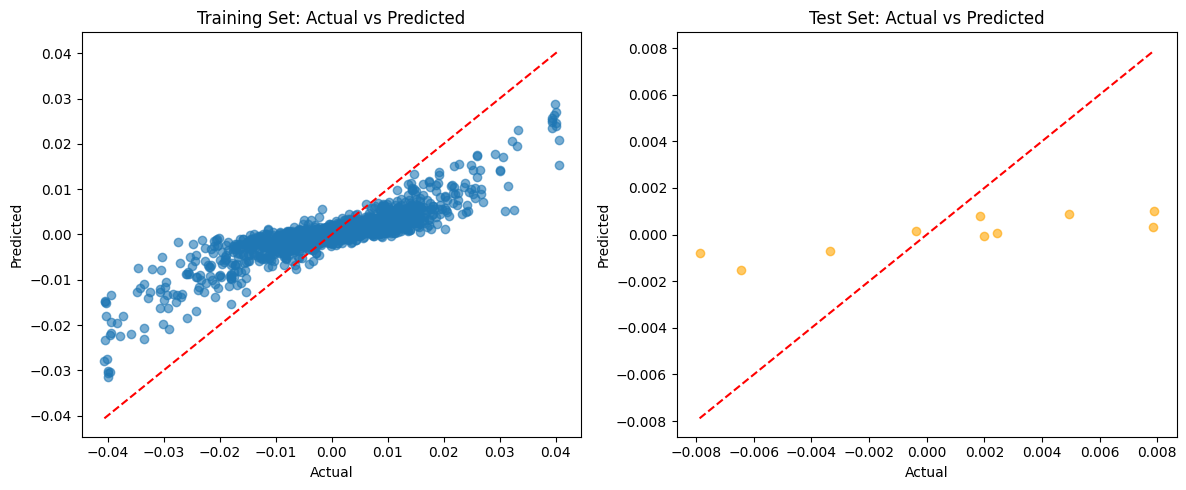

In [ ]:
# Predictions
y_train_pred = model.predict(X_train)#model.predict(X_train)# pipe.predict(X_train)#
y_test_pred = model.predict(X_test)# #pipe.predict(X_test)#model.predict(X_test)

# Evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

# Training performance
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')

# Test performance
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='orange')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.tight_layout()
plt.show()

In [ ]:
# import shap

# # Create explainer
# explainer = shap.Explainer(model)
# shap_values = explainer(X_train.to_pandas())

# # Plot summary
# shap.summary_plot(shap_values, X_train.to_pandas(), plot_type="bar")


All feats: 9.419272339746476 <br>
Baseline: 9.35143680081713 <br>
TSCV: 2.2582225113042416 <br>
hyperparam tune r2: 1.877413472278813 <br>
hyperparam tune rmse: 9.919875445392723 <br>
comp:  9.920277079486265 <br>
select_from_rf: 9.920286456857399 (0.16781785001727625)<br>

new_base: 4.74902218513571 <br>
with lag feats: 4.737821744034145 <br>

In [ ]:
solution = feat_eng(load_trainset()).with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).select(FEATURES + ['risk_free_rate',
 'target', 'forward_returns']).drop_nulls().to_pandas()


solution['prediction'] = convert_ret_to_signal(y_train_pred, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

7.0785005770379215

In [ ]:
solution['prediction'] = nonlinear_signal(y_train_pred)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

1.020205326000594

In [ ]:
solution['prediction'] = np.where(
    y_train_pred> 0,              # condition
    np.clip(y_train_pred / 0.02, 0.0, 1.5),  # scale and clip between 0.0 and 1.5
    0.0                      # else
)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')


3.7573442682640192

In [ ]:
score(solution, solution[['prediction']], row_id_column_name = 'date_id')

0.5453853138363242

#### Optuna
-do weighted rmse scoring + add scoring function scoring try

In [ ]:
%%capture
!pip install optuna

In [ ]:
import optuna
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer


# Define your CV strategy
tscv = TimeSeriesSplit(n_splits=5)

# def objective(trial):
#     # Suggest hyperparameters
#     params = {
#         # "loss": "squared_error",
#         # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#         # "max_iter": trial.suggest_int("max_iter", 200, 1200),
#         # "max_depth": trial.suggest_int("max_depth", 3, 12),
#         # "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
#         # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
#         # "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
#         # "max_features": trial.suggest_float("max_features", 0.5, 1.0),
#         # "max_bins": trial.suggest_int("max_bins", 2, 255),
#         # "early_stopping": False,  # disable internal early stopping for fair CV comparison
#         # "random_state": 30,
#         "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error"]),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#         "max_iter": trial.suggest_int("max_iter", 200, 1200),
#         "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
#         "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
#         "max_bins": trial.suggest_int("max_bins", 2, 255),
#         "early_stopping": False,   # Disable for fair CV comparison
#         "validation_fraction": 0.1,
#         "n_iter_no_change": 10,
#         "tol": 1e-7,
#         "random_state": 30,
#         "verbose": 0
#     }

#     model = HistGradientBoostingRegressor(**params)

#     # Evaluate with time-series cross-validation (R²)
#     scores = cross_val_score(
#         model,
#         X_train,
#         y_train,
#         cv=tscv,
#         scoring = make_scorer(mean_squared_error, greater_is_better=False), #make_scorer(mean_squared_error, greater_is_better=False), #make_scorer(r2_score),
#         n_jobs=-1
#     )
#     # Later folds get higher weights: 1, 2, 3, ...
#     weights = np.arange(1, len(scores) + 1)

#     # Weighted average (later folds weighted more)
#     weighted_mean = np.average(scores, weights=weights)

#     # Return score across folds
#     return weighted_mean

def objective(trial):
    params = {
        "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 200, 1200),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
        "max_bins": trial.suggest_int("max_bins", 2, 255),
        "early_stopping": False,
        "validation_fraction": 0.1,
        "n_iter_no_change": 10,
        "tol": 1e-7,
        "random_state": 30,
        "verbose": 0
    }

    model = HistGradientBoostingRegressor(**params)

    # --- Static split (last 180 are the validation set) ---
    split_idx = X_train.height - 180
    X_tr = X_train.slice(0, split_idx)
    X_val = X_train.slice(split_idx)
    y_tr = y_train.slice(0, split_idx)
    y_val = y_train.slice(split_idx)

    # Train + evaluate
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)

    # Use R² as metric (you can switch this to RMSE if you prefer)
    # score = r2_score(y_val, preds)
    solution = feat_eng(load_trainset()).with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
    ]).select(FEATURES + ['risk_free_rate',
 'target', 'forward_returns']).drop_nulls().slice(split_idx).to_pandas()


    solution['prediction'] = convert_ret_to_signal(preds, ret_signal_params)

    score = score2(solution, solution[['prediction']], row_id_column_name = 'date_id')

    return score  # Optuna will maximize this


# Create and run the study
study = optuna.create_study(direction="maximize", study_name="HGBR_time_series_opt_scoring")
study.optimize(objective, n_trials=100, timeout=3600, show_progress_bar=True)
study.trials_dataframe().to_csv("/content/drive/MyDrive/Output/Hyperparams/hull_tactical_optuna_hgbr_results_scoring.csv", index=False)



[I 2025-12-09 16:47:57,969] A new study created in memory with name: HGBR_time_series_opt_scoring


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-09 16:49:11,026] Trial 0 finished with value: 0.3962625231071703 and parameters: {'loss': 'squared_error', 'learning_rate': 0.002395338193558287, 'max_iter': 1061, 'max_leaf_nodes': 92, 'max_depth': 5, 'min_samples_leaf': 91, 'l2_regularization': 0.1408231588323318, 'max_bins': 45}. Best is trial 0 with value: 0.3962625231071703.
[I 2025-12-09 16:50:56,990] Trial 1 finished with value: 0.5141743277573969 and parameters: {'loss': 'squared_error', 'learning_rate': 0.05443048742350196, 'max_iter': 1043, 'max_leaf_nodes': 177, 'max_depth': 3, 'min_samples_leaf': 47, 'l2_regularization': 0.13176063573764712, 'max_bins': 190}. Best is trial 1 with value: 0.5141743277573969.
[I 2025-12-09 16:52:12,634] Trial 2 finished with value: 0.09824374567089307 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.02993641411051912, 'max_iter': 897, 'max_leaf_nodes': 29, 'max_depth': 4, 'min_samples_leaf': 51, 'l2_regularization': 0.15101939239468068, 'max_bins': 68}. Best is trial 1 

In [ ]:
study.best_params

{'loss': 'squared_error',
 'learning_rate': 0.008975489544720622,
 'max_iter': 523,
 'max_leaf_nodes': 251,
 'max_depth': 8,
 'min_samples_leaf': 24,
 'l2_regularization': 0.005066288703886804,
 'max_bins': 93}

rmse:  -0.00011718793390904168 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.0016312140804009279, 'max_iter': 391, 'max_leaf_nodes': 197, 'max_depth': 3, 'min_samples_leaf': 94, 'l2_regularization': 0.001538815894432757, 'max_bins': 112} <br>

scoring: 1.483073902063297 and parameters: {'loss': 'squared_error', 'learning_rate': 0.26631810548668566, 'max_iter': 1127, 'max_leaf_nodes': 27, 'max_depth': 3, 'min_samples_leaf': 49, 'l2_regularization': 0.0048060975752142274, 'max_bins': 208}

1.3743442556420302 :{'loss': 'squared_error',
 'learning_rate': 0.008975489544720622,
 'max_iter': 523,
 'max_leaf_nodes': 251,
 'max_depth': 8,
 'min_samples_leaf': 24,
 'l2_regularization': 0.005066288703886804,
 'max_bins': 93}



In [ ]:
# Best results
print("Best R² Score:", study.best_value)
print("Best Parameters:", study.best_params)


# Refit the final model on the full training set
best_model = HistGradientBoostingRegressor(**study.best_params)
best_model.fit(X_train, y_train)

Best R² Score: 0.07253716560888823
Best Parameters: {'loss': 'squared_error', 'learning_rate': 0.00737795745506236, 'max_iter': 601, 'max_leaf_nodes': 114, 'max_depth': 4, 'min_samples_leaf': 10, 'l2_regularization': 1.7931711881472216e-05, 'max_bins': 32}


HistGradientBoostingRegressor(l2_regularization=1.7931711881472216e-05,
                              learning_rate=0.00737795745506236, max_bins=32,
                              max_depth=4, max_iter=601, max_leaf_nodes=114,
                              min_samples_leaf=10)

## GRU
1. Add loss/scoring on the last 180
2. hyper param experiment, early stop
3. feature engineer
df['returns_lag_5'] = df['forward_returns'].shift(5)
df['high_vol_regime'] = (recent_volatility > normal_volatility)
4. **rolling stats**
5. **Online learning** - https://www.kaggle.com/code/youneseloiarm/hull-tactical-ensembling-trees-online-training-001
6. window parameter edits

In [ ]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
from dataclasses import dataclass, asdict

import polars as pl
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor

# Config
# ============ PATHS ============
DATA_PATH: Path = Path('/content/')

# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal
SIGNAL_MULTIPLIER: float = 400.0                # Multiplier of the OLS market forward excess returns predictions to signal

# ============ MODEL CONFIGS ============
CV: int = 10                                    # Number of cross validation folds in the model fitting
L1_RATIO: float = 0.5                           # ElasticNet mixing parameter
ALPHAS: np.ndarray = np.logspace(-4, 2, 100)    # Constant that multiplies the penalty terms
MAX_ITER: int = 1000000                         # The maximum number of iterations


@dataclass
class DatasetOutput:
    X_train : pl.DataFrame
    X_test: pl.DataFrame
    y_train: pl.Series
    y_test: pl.Series
    scaler: StandardScaler

@dataclass
class ElasticNetParameters:
    l1_ratio : float
    cv: int
    alphas: np.ndarray
    max_iter: int

    def __post_init__(self):
        if self.l1_ratio < 0 or self.l1_ratio > 1:
            raise ValueError("Wrong initializing value for ElasticNet l1_ratio")

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL


# Set Parameters
ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

enet_params = ElasticNetParameters(
    l1_ratio = L1_RATIO,
    cv = CV,
    alphas = ALPHAS,
    max_iter = MAX_ITER
)

In [ ]:
# Helper Functions
def load_trainset() -> pl.DataFrame:
    """
    Loads and preprocesses the training dataset.

    Returns:
        pl.DataFrame: The preprocessed training DataFrame.
    """

    return (
    pl.read_csv(DATA_PATH / "train.csv")
    .rename({"market_forward_excess_returns": "target"})
    .with_columns(
        pl.exclude("date_id").cast(pl.Float64, strict=False)
    )
    .with_columns(
        (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2"),
        (pl.col("date_id") % 5).alias("day_of_week"),
        ((pl.col("date_id") // 20) % 12).alias("month")
    )
    .with_columns([
        # Cyclic encoding for day_of_week (period = 5)
        (pl.col("day_of_week") * (2 * np.pi / 5)).sin().alias("day_of_week_sin"),
        (pl.col("day_of_week") * (2 * np.pi / 5)).cos().alias("day_of_week_cos"),

        # Cyclic encoding for month (period = 12)
        (pl.col("month") * (2 * np.pi / 12)).sin().alias("month_sin"),
        (pl.col("month") * (2 * np.pi / 12)).cos().alias("month_cos"),
    ])
    # .head(-10)
)

def load_testset() -> pl.DataFrame:
    """
    Loads and preprocesses the testing dataset.

    Returns:
        pl.DataFrame: The preprocessed testing DataFrame.
    """
    return (
        pl.read_csv(DATA_PATH / "test.csv")
        .rename({'lagged_forward_returns':'target'})
        .with_columns(
        pl.exclude("date_id").cast(pl.Float64, strict=False)
    )
    .with_columns(
        (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2"),
        (pl.col("date_id") % 5).alias("day_of_week"),
        ((pl.col("date_id") // 20) % 12).alias("month")
    )
    .with_columns([
        # Cyclic encoding for day_of_week (period = 5)
        (pl.col("day_of_week") * (2 * np.pi / 5)).sin().alias("day_of_week_sin"),
        (pl.col("day_of_week") * (2 * np.pi / 5)).cos().alias("day_of_week_cos"),

        # Cyclic encoding for month (period = 12)
        (pl.col("month") * (2 * np.pi / 12)).sin().alias("month_sin"),
        (pl.col("month") * (2 * np.pi / 12)).cos().alias("month_cos"),
    ])
    )

def create_example_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """
    Creates new features and cleans a DataFrame.

    Args:
        df (pl.DataFrame): The input Polars DataFrame.

    Returns:
        pl.DataFrame: The DataFrame with new features, selected columns, and no null values.
    """
    vars_to_keep = [
        "S2", "E2", "E3", "P9", "S1", "S5", "I2", "P8",
        "P10", "P12", "P13", "U1", "U2"
    ]

    return (
        df.with_columns(
            (pl.col("I2") - pl.col("I1")).alias("U1"),
            (pl.col("M11") / ((pl.col("I2") + pl.col("I9") + pl.col("I7")) / 3)).alias("U2")
        )
        .select(["date_id", "target"] + vars_to_keep)
        .with_columns([
            pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5))
            for col in vars_to_keep
        ])
        .drop_nulls()
    )

def join_train_test_dataframes(train: pl.DataFrame, test: pl.DataFrame) -> pl.DataFrame:
    """
    Joins two dataframes by common columns and concatenates them vertically.

    Args:
        train (pl.DataFrame): The training DataFrame.
        test (pl.DataFrame): The testing DataFrame.

    Returns:
        pl.DataFrame: A single DataFrame with vertically stacked data from common columns.
    """
    common_columns: list[str] = [col for col in train.columns if col in test.columns]

    return pl.concat([train.select(common_columns), test.select(common_columns)], how="vertical")

def split_dataset(train: pl.DataFrame, test: pl.DataFrame, features: list[str]) -> DatasetOutput:
    """
    Splits the data into features (X) and target (y), and scales the features.

    Args:
        train (pl.DataFrame): The processed training DataFrame.
        test (pl.DataFrame): The processed testing DataFrame.
        features (list[str]): List of features to used in model.

    Returns:
        DatasetOutput: A dataclass containing the scaled feature sets, target series, and the fitted scaler.
    """
    X_train = train.drop(['date_id','target'])
    y_train = train.get_column('target')
    X_test = test.drop(['date_id','target'])
    y_test = test.get_column('target')

    scaler = StandardScaler() #MinMaxScaler() #StandardScaler()

    X_train_scaled_np = scaler.fit_transform(X_train)
    X_train = pl.from_numpy(X_train_scaled_np, schema=features)

    X_test_scaled_np = scaler.transform(X_test)
    X_test = pl.from_numpy(X_test_scaled_np, schema=features)


    return DatasetOutput(
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
        scaler = scaler
    )

In [ ]:
def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    return np.clip(
        ret_arr * params.signal_multiplier + 1, params.min_signal, params.max_signal
    )

def zscore_ret_to_signal(ret_arr, lookback=100, clip_range=(0, 2)):
    mean = np.mean(ret_arr[-lookback:])
    std = np.std(ret_arr[-lookback:])
    zscores = (ret_arr - mean) / (std + 1e-8)
    return np.clip(1 + zscores * 0.2, *clip_range)

def quantile_signal(ret_arr, n_quantiles=5, clip_range=(0, 2)):
    ranks = pd.qcut(ret_arr, n_quantiles, labels=False, duplicates='drop')
    return np.clip(1 + (ranks - n_quantiles//2) / (n_quantiles//2), *clip_range)

def vol_adjusted_signal(ret_arr, vol_arr, target_vol=0.02, clip_range=(0, 2)):
    adj_signal = 1 + (ret_arr / (vol_arr + 1e-8)) * target_vol
    return np.clip(adj_signal, *clip_range)

def nonlinear_signal(ret_arr, params: RetToSignalParameters):
    signal = 1 + np.tanh(params.signal_multiplier * ret_arr)
    return np.clip(signal, params.min_signal, params.max_signal)

def threshold_signal(ret_arr, pos_thresh=0.01, neg_thresh=-0.01):
    signal = np.where(ret_arr > pos_thresh, 2, np.where(ret_arr < neg_thresh, 0, 1))
    return signal

In [ ]:
train = load_trainset()
test = load_testset()

train = train.sort("date_id")
test = test.sort("date_id")

market_cols = ['M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
macro_cols = ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6',
              # 'E7',
              'E8', 'E9']
rate_cols = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
price_cols = ['P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
vol_cols = ['V1',
            # 'V10',
            'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
sent_cols = ['S1', 'S10', 'S11', 'S12', 'S2',
            #  'S3',
             'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
# mom_cols = [c for c in df.columns if c.startswith("MOM")]
dummy_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
to_drop = ['E7', 'V10', 'S3']

df = join_train_test_dataframes(train, test)
df = df.unique(subset=["date_id"], keep="first")
df = df.drop([c for c in to_drop if c in df.columns])

In [ ]:
# train.tail().null_count().to_pandas().T.sort_values(0).tail(50)

In [ ]:
# train.null_count().to_pandas().T.sort_values(0).tail(50)

In [12]:
# Feat engineer
def std_horizontal(cols: list[str]) -> pl.Expr:
    mean = pl.mean_horizontal(cols)
    return ((sum((pl.col(c) - mean) ** 2 for c in cols) / len(cols)).sqrt())

def feat_eng(df):
  df = df.with_columns([
      # Mean and standard deviation across M features
      pl.mean_horizontal(market_cols).alias("M_mean"),
      std_horizontal(market_cols).alias("M_std"),
      # Normalized versions (z-scores)
      *[
          ((pl.col(c) - pl.mean_horizontal(market_cols)) / std_horizontal(market_cols)).alias(f"{c}_z")
          for c in market_cols
      ],
  ])

  # Momentum
  df = df.with_columns([
      pl.mean_horizontal(macro_cols).alias("E_composite"),
      (pl.max_horizontal(macro_cols) - pl.min_horizontal(macro_cols)).alias("E_range"),
  ])

  df = df.with_columns([
      (pl.col("E_composite") - pl.col("E_composite").shift(5)).alias(f"E_5d_change")
  ])
  # for c in macro_cols:
  #     df = df.with_columns(
  #         (pl.col(c) - pl.col(c).shift(5)).alias(f"{c}_5d_change")
  #     )

  # Interest Rates
  df = df.with_columns([
      pl.mean_horizontal(rate_cols).alias("I_avg_yield"),
      (pl.col("I1") - pl.col("I9")).alias("I_yield_spread"),  # short vs long
      (pl.col("I1") - pl.col("I1").shift(5)).alias("I_short_rate_change_5d"),
  ])

  # Price Valuation
  df = df.with_columns([
      pl.mean_horizontal(price_cols).alias("P_mean"),
      (pl.max_horizontal(price_cols) / (pl.min_horizontal(price_cols) + 1e-9)).alias("P_ratio_range"),
  ])

  # for c in price_cols:
  #     df = df.with_columns([
  #         (pl.col(c) - pl.col(c).shift(5)).alias(f"{c}_5d_momentum"),
  #     ])

  # Add vol (Lose a lot of rows)
  df = df.with_columns([
      pl.mean_horizontal(vol_cols).alias("V_mean"),
      std_horizontal(vol_cols).alias("V_std"),
      *[
          (pl.col(col).abs() + 1e-6).log1p().fill_nan(0).alias(f"{col}_log_vol")
          for col in vol_cols
      ],
  ])

  # # Add Sent
  df = df.with_columns([
      pl.mean_horizontal(sent_cols).alias("S_mean"),
      pl.max_horizontal(sent_cols).alias("S_max"),
      (pl.col("S1") - pl.col("S1").shift(5)).alias("S1_5d_delta"),
  ])

  # # Dummy
  df = df.with_columns([
      pl.sum_horizontal(dummy_cols).alias("D_sum_active"),
  ])
  df = df.with_columns([
      # (pl.col("M_mean") + pl.col("MOM_mean") - pl.col("V_mean")).alias("risk_adjusted_momentum"),
      (pl.col("S_mean") * pl.col("E_composite")).alias("macro_sentiment_signal"),
  ])

  # new Feats
  df = df.with_columns([
      pl.col("target").shift(5).alias("returns_lag_5")
  ])

  # Vol features
  # log_vol_cols = [f"{col}_log_vol" for col in vol_cols]

  # recent_window = 20
  # normal_window = 60
  # k = 1.0   # optional if using V_mean + k·V_std

  # df = df.with_columns([
  #     # 3. Recent volatility (short-term)
  #   pl.mean_horizontal(log_vol_cols)
  #     .rolling_std(window_size=recent_window)
  #     .alias("recent_volatility"),

  #   # 4. Normal volatility (long-term baseline)
  #   pl.mean_horizontal(log_vol_cols)
  #     .rolling_std(window_size=normal_window)
  #     .alias("normal_volatility"),

  # ])
  # df = df.with_columns([# 5. High-volatility regime
  #   (pl.col("recent_volatility") > pl.col("normal_volatility"))
  #     .alias("high_vol_regime"),])

  df = df.with_columns([
        # 1. Yield Curve Curvature (Convexity)
        # If High: Mid-term rates are high relative to wings (humped)
        (2 * pl.col("I5") - (pl.col("I1") + pl.col("I9"))).alias("I_curvature"),

        # 2. Real Rates Proxy (Interest Rate - Inflation/Macro)
        # Assuming E_composite proxies for inflation/growth
        (pl.col("I_avg_yield") - pl.col("E_composite")).alias("I_real_rate_proxy"),

        # 3. Volatility-Adjusted Momentum
        # (Price Return / Volatility)
        ((pl.col("P_mean") - pl.col("P_mean").shift(5)) /
         (pl.col("V_mean") + 1e-9)).alias("risk_adjusted_return_5d")
    ])

  df = df.with_columns([
        # 1. Price/Sentiment Divergence
        # We look at the ratio of Z-scores.
        # If Price Z is -2 and Sentiment Z is +2, ratio is -1 (Strong divergence)
        # ((pl.col("P_mean") - pl.col("P_mean").rolling_mean(20)) * (pl.col("S_mean") - pl.col("S_mean").rolling_mean(20)))
        #  .alias("P_S_interaction"),

        # 2. Macro Stability vs Market Fear
        # High Macro Range * High Volatility = High Stress Environment
        (pl.col("E_range") * pl.col("V_mean")).alias("Systemic_Stress_Index")
    ])

  # Coefficient of Variation for Market columns
  # Low CV = Tight grouping (Consensus). High CV = Disagreement.
  df = df.with_columns([
        (std_horizontal(market_cols) / (pl.mean_horizontal(market_cols).abs() + 1e-9))
        .alias("M_coeff_variation")
    ])

  return df

df = df.sort("date_id")
df = feat_eng(df)
df.shape, df.drop_nulls().shape

((9048, 154), (3501, 154))

In [13]:
# df.null_count().to_pandas().T.sort_values(0).tail(10)

In [14]:
model_a_feats = {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 1, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 1, 'I1': 1, 'I2': 1, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 0, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 0, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 0, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos': 0, 'M_mean': 1, 'M_std': 1, 'M14_z': 1, 'M15_z': 1, 'M16_z': 0, 'M17_z': 0, 'M18_z': 0, 'M3_z': 1, 'M4_z': 1, 'M6_z': 1, 'M8_z': 1, 'M9_z': 0, 'E_composite': 0, 'E_range': 1, 'E_5d_change': 1, 'I_short_rate_change_5d': 1, 'P_mean': 1, 'P_ratio_range': 1, 'V_mean': 0, 'V_std': 0, 'V13_log_vol': 0, 'V5_log_vol': 1, 'V7_log_vol': 1, 'S_mean': 0, 'S_max': 0, 'S1_5d_delta': 0, 'D_sum_active': 1, 'macro_sentiment_signal': 1, 'returns_lag_5': 1, 'I_real_rate_proxy': 1, 'risk_adjusted_return_5d': 0, 'Systemic_Stress_Index': 1, 'M_coeff_variation': 1}
model_a_feats = [k for k, v in model_a_feats.items() if v == 1]

model_b_feats = {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 1, 'M_mean': 0, 'M_std': 0, 'M14_z': 0, 'M15_z': 0, 'M16_z': 0, 'M17_z': 1, 'M18_z': 0, 'M3_z': 0, 'M4_z': 0, 'M6_z': 0, 'M8_z': 1, 'M9_z': 1, 'E_composite': 1, 'E_range': 1, 'E_5d_change': 1, 'I_short_rate_change_5d': 0, 'P_mean': 0, 'P_ratio_range': 0, 'V_mean': 1, 'V_std': 1, 'V13_log_vol': 1, 'V5_log_vol': 0, 'V7_log_vol': 1, 'S_mean': 1, 'S_max': 0, 'S1_5d_delta': 1, 'D_sum_active': 1, 'macro_sentiment_signal': 0, 'returns_lag_5': 0, 'I_real_rate_proxy': 0, 'risk_adjusted_return_5d': 0, 'Systemic_Stress_Index': 1, 'M_coeff_variation': 1}
model_b_feats = [k for k, v in model_b_feats.items() if v == 1]

In [15]:
df = df.sort("date_id")
df = df.with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls()

# df = df.with_columns([
#     pl.col(c).fill_null(0).alias(c)
#     for c in df.columns
# ]).drop_nulls()
# df = create_example_dataset(df=df)

drop = ['D2',
 'E17',
 'I9',
 'P11',
 'V4',
 'V9',
 'U1',
 'M1_z',
 'M10_z',
 'M11_z',
 'M12_z',
 'M13_z',
 'M2_z',
 'M5_z',
 'M7_z',
 'I_avg_yield',
 'I_yield_spread',
 'V1_log_vol',
 'V11_log_vol',
 'V12_log_vol',
 'V2_log_vol',
 'V3_log_vol',
 'V4_log_vol',
 'V6_log_vol',
 'V8_log_vol',
 'V9_log_vol',
 'I_curvature']

# Train test split
train = df.filter(pl.col('date_id').is_in(train.get_column('date_id'))).drop(drop).sort("date_id")
test = df.filter(pl.col('date_id').is_in(test.get_column('date_id'))).drop(drop).sort("date_id")

FEATURES = [col for col in test.columns if col not in ['date_id', 'target']]
# feats = ['E10', 'E19', 'E2', 'E3', 'E7', 'E9', 'I2', 'I3', 'I4', 'I7', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M2', 'M3', 'M4', 'M8', 'M9', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S8', 'S9', 'V13', 'V5', 'V7', 'V9', 'M1_z', 'M10_z', 'M11_z', 'M12_z', 'M13_z', 'M14_z', 'M16_z', 'M17_z', 'M2_z', 'M3_z', 'M4_z', 'M8_z', 'M9_z', 'E_range', 'I_avg_yield', 'P_mean', 'P_ratio_range', 'V_mean', 'V_std', 'V13_log_vol', 'V5_log_vol', 'V7_log_vol', 'V9_log_vol', 'S_mean', 'S_max', 'macro_sentiment_signal']


dataset = split_dataset(train=train, test=test, features=FEATURES)


# X_train = dataset.X_train#[feats]
# X_test = dataset.X_test#[feats]
# y_train = dataset.y_train
# y_test = dataset.y_test
# scaler = dataset.scaler

df.shape

/tmp/ipython-input-2258565833.py:42: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train = df.filter(pl.col('date_id').is_in(train.get_column('date_id'))).drop(drop).sort("date_id")
/tmp/ipython-input-2258565833.py:43: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  test = df.filter(pl.col('date_id').is_in(test.get_column('date_id'))).drop(drop).sort("date_id")


(3501, 154)

In [24]:
# ============================================================
# CONFIG
# ============================================================
SEQ_LEN = 5       # 5-day window
PRED_LEN = 1      # predict 1 day ahead
BATCH_SIZE = 32
EPOCHS = 100

SEED = 30
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Stop training if validation loss doesn't improve for 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',    # monitor validation loss
    patience=10,           # number of epochs with no improvement after which training stops
    restore_best_weights=True,  # restore weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# ============================================================
# CONFIG END
# ============================================================

def build_sequences_only_X(X, seq_len):
    X_seq = []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i+seq_len])
    return np.array(X_seq)

def build_sequences(X, y, seq_len=5, pred_len=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len - pred_len + 1):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len:i+seq_len+pred_len])
    return np.array(X_seq), np.array(y_seq)

def build_model_data(dataset, feats):
  X_train = dataset.X_train[feats]
  X_test = dataset.X_test[feats]
  y_train = dataset.y_train
  y_test = dataset.y_test
  scaler = dataset.scaler

  N = 180
  X_last = X_train[-(N + SEQ_LEN-1):]   # need extra 5 days to build 180 windows
  y_last = y_train[-N:]


  # X_last_scaled = scaler.transform(X_last)
  X_last_seq = build_sequences_only_X(X_last, SEQ_LEN)

  # Scale features
  X_train_scaled = X_train[:-(N + SEQ_LEN-1)]
  X_test_scaled  = X_test

  # Convert y from Polars Series → NumPy → reshape
  y_train_scaled = y_train[:-N].to_numpy().reshape(-1, 1)
  y_test_scaled  = y_test.to_numpy().reshape(-1, 1)


  # Build sequences
  X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled)
  X_test_seq,  y_test_seq  = build_sequences(X_test_scaled,  y_test_scaled)

  num_features = X_train.shape[1]

  return X_train_seq, y_train_seq, X_test_seq,  y_test_seq, num_features, X_last_seq, y_last

In [25]:
X_train_seq, y_train_seq, X_test_seq,  y_test_seq, num_features, X_last_seq, y_last = build_model_data(dataset, model_a_feats)

model_a = tf.keras.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(SEQ_LEN, num_features)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model_a.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_a = model_a.fit(
    X_train_seq, y_train_seq,
    validation_data= (X_last_seq, y_last), #(X_test_seq, y_test_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stop],
)

pred_a = model_a.predict(X_last_seq)
y_true_a = y_last.to_numpy().reshape(-1, 1).reshape(-1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 0.0197 - mae: 0.1042 - val_loss: 4.5424e-04 - val_mae: 0.0170
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0035 - mae: 0.0456 - val_loss: 4.3758e-04 - val_mae: 0.0168
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0020 - mae: 0.0346 - val_loss: 2.1125e-04 - val_mae: 0.0118
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 1.3463e-04 - val_mae: 0.0087
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 9.4933e-04 - mae: 0.0242 - val_loss: 1.2311e-04 - val_mae: 0.0079
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.1083e-04 - mae: 0.0212 - val_loss: 1.5865e-04 - val_mae: 0.0098
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.7545e-04 - mae: 0.0187 - val_loss: 1.1229e-04 - val_mae: 0.0075
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.6867e-04 - mae: 0.0166 - val_loss: 1.4347e-04 - val_mae

In [26]:
X_train_seq, y_train_seq, X_test_seq,  y_test_seq, num_features, X_last_seq, y_last = build_model_data(dataset, model_b_feats)

model_b = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(SEQ_LEN, num_features)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model_b.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_b = model_b.fit(
    X_train_seq, y_train_seq,
    validation_data= (X_last_seq, y_last),#(X_test_seq, y_test_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stop],
)

pred_b = model_b.predict(X_last_seq)
y_true_b = y_last.to_numpy().reshape(-1, 1).reshape(-1)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0701 - mae: 0.1956 - val_loss: 0.0028 - val_mae: 0.0424
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - mae: 0.0727 - val_loss: 9.1467e-04 - val_mae: 0.0251
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0035 - mae: 0.0466 - val_loss: 4.1958e-04 - val_mae: 0.0165
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 2.9381e-04 - val_mae: 0.0136
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 2.1552e-04 - val_mae: 0.0111
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6521e-04 - mae: 0.0208 - val_loss: 1.9253e-04 - val_mae: 0.0105
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2120e-04 - mae: 0.0168 - val_loss: 1.4013e-04 - val_mae: 0.0084
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8204e-04 - mae: 0.0144 - val_loss: 1.2656e-04 - val_mae: 0.0078
Epoch

In [ ]:
# display(model_a.summary())
# model_b.summary()

In [27]:
# ============================================================
# STEP 5 — PREDICT + INVERSE SCALE
# ============================================================
# pred_a = model_a.predict(X_test_seq)
# pred_b = model_b.predict(X_test_seq)

# # ensemble
# pred_avg_scaled = (pred_a + pred_b) / 2.0
pred_avg_scaled = (pred_a + pred_b) / 2.0  # ensemble

# Inverse scaling
# pred = scaler.inverse_transform(pred_avg_scaled)
# pred = scaler.inverse_transform(pred_a)
# y_true = scaler.inverse_transform(y_test_seq)

# # Flatten
pred_a = pred_a.reshape(-1)
pred_b = pred_b.reshape(-1)
pred_e = pred_avg_scaled.reshape(-1)

In [28]:
y_true = y_last.to_numpy().reshape(-1, 1).reshape(-1)

In [29]:
solution = feat_eng(load_trainset()).with_columns([
    pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
    for c in df.columns
]).drop_nulls().to_pandas().iloc[-180:]


solution['prediction'] = convert_ret_to_signal(pred_a, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

1.0507431033580343

In [30]:
solution['prediction'] = nonlinear_signal(pred_a, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

1.0679072483745427

In [31]:
solution['prediction'] = convert_ret_to_signal(pred_b, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

1.1945001864786469

In [32]:
solution['prediction'] = nonlinear_signal(pred_b, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

1.1939274097775627

In [33]:
solution['prediction'] = convert_ret_to_signal(pred_e, ret_signal_params)

print(score(solution, solution[['prediction']], row_id_column_name = 'date_id'))

solution['prediction'] = nonlinear_signal(pred_e, ret_signal_params)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

1.0442209958266435


1.11088115872358

In [ ]:
def tmp(x):
  return min(1.5, max(0.0, x / 0.02)) if x > 0 else 0.0

solution['prediction'] = np.where(
    pred_b > 0,              # condition
    np.clip(pred_b / 0.02, 0.0, 1.5),  # scale and clip between 0.0 and 1.5
    0.0                      # else
)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

0.19600223183786872

In [ ]:
solution['prediction'] = np.where(
    np.abs(pred_b) < 0.01,                      # condition: abs(x) < 0.01
    np.clip(pred_b * 15, 0.0, 1.0),            # then: x*15 clipped between 0 and 1
    np.where(pred_b > 0, 0.5, 0.0)             # else: 0.5 if x>0 else 0
)

score(solution, solution[['prediction']], row_id_column_name = 'date_id')

0.19088796755008167

In [ ]:
# ============================================================
# STEP 6 — METRICS
# ============================================================
a_rmse = np.sqrt(mean_squared_error(y_true, pred_a))
a_r2 = r2_score(y_true, pred_a)

b_rmse = np.sqrt(mean_squared_error(y_true, pred_b))
b_r2 = r2_score(y_true, pred_b)

e_rmse = np.sqrt(mean_squared_error(y_true, pred_e))
e_r2 = r2_score(y_true, pred_e)

print(f"Final RMSE: {a_rmse:.6f}")
print(f"Final R2: {a_r2:.6f}")
print()
print(f"Final RMSE: {b_rmse:.6f}")
print(f"Final R2: {b_r2:.6f}")
print()
print(f"Final RMSE: {e_rmse:.6f}")
print(f"Final R2: {e_r2:.6f}")

Final RMSE: 0.010310
Final R2: 0.000680

Final RMSE: 0.010321
Final R2: -0.001589

Final RMSE: 0.010299
Final R2: 0.002691


#### Forward Feature Selection

In [ ]:
corr = X_train.to_pandas().corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.92)]
X_train_filtered = X_train.drop(to_drop, axis=1)


TypeError: DataFrame.drop() got an unexpected keyword argument 'axis'

In [ ]:
to_drop

['S11', 'M3_z', 'M4_z', 'M9_z']

In [ ]:
def evaluate_feature_subset(feature_list,
                            SEQ_LEN=5,
                            PRED_LEN=1,
                            BATCH_SIZE=32,
                            EPOCHS=40):

    # ------------------------
    # 1. Use only selected features
    # ------------------------
    X_train_sub = X_train[feature_list]
    X_test_sub  = X_test[feature_list]

    # ------------------------
    # 2. Fit new scaler
    # ------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sub[:-(N + SEQ_LEN - 1)])
    X_test_scaled  = scaler.transform(X_test_sub)

    # ------------------------
    # 3. Build sequences (same as your code)
    # ------------------------
    y_train_sub = y_train[:-N].to_numpy().reshape(-1,1)
    y_test_sub  = y_test.to_numpy().reshape(-1,1)

    X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_sub, SEQ_LEN, PRED_LEN)
    X_test_seq,  y_test_seq  = build_sequences(X_test_scaled,  y_test_sub,  SEQ_LEN, PRED_LEN)

    # ------------------------
    # 4. Build prediction dataset X_last
    # ------------------------
    X_last_sub = X_train_sub[-(N + SEQ_LEN - 1):]
    X_last_scaled = scaler.transform(X_last_sub)
    X_last_seq = build_sequences_only_X(X_last_scaled, SEQ_LEN)

    # ------------------------
    # 5. Build new GRU model
    # ------------------------
    num_features = len(feature_list)

    # model = tf.keras.Sequential([
    #     tf.keras.layers.GRU(128, return_sequences=True, input_shape=(SEQ_LEN, num_features)),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.GRU(128, return_sequences=True),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.GRU(128),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.Dense(1)
    # ])

    model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(SEQ_LEN, num_features)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=0
    )

    # ------------------------
    # 6. Train
    # ------------------------
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_last_seq, y_last),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stop]
    )

    # ------------------------
    # 7. Predict last 180 days
    # ------------------------
    preds = model.predict(X_last_seq).reshape(-1)

    # ------------------------
    # 8. Score using your framework
    # ------------------------
    solution = feat_eng(load_trainset()).with_columns([
        pl.col(c).fill_null(pl.col(c).ewm_mean(com=0.5)).alias(c)
        for c in df.columns
    ]).drop_nulls().to_pandas().iloc[-180:]

    solution['prediction'] = convert_ret_to_signal(preds, ret_signal_params)

    y_true = y_last.to_numpy().reshape(-1, 1).reshape(-1)
    b_r2 = r2_score(y_true, preds)

    value = score(solution, solution[['prediction']], row_id_column_name='date_id')

    return value * b_r2


In [ ]:
def forward_feature_selection(
    all_features,
    tolerance=0.001,
    selected=None
):
    # If user did not pass selected list → start empty
    if selected is None:
        selected = []
    else:
        # Ensure copy so original isn't mutated
        selected = list(selected)

    # Remove already-selected features from remaining pool
    remaining = [f for f in all_features if f not in selected]

    # If starting from a non-empty selection,
    # compute its baseline score once.
    if len(selected) > 0:
        print(f"\nStarting from existing feature set ({len(selected)} features).")
        print("Selected:", selected)
        best_score = evaluate_feature_subset(selected)
        print(f"Baseline score = {best_score:.6f}")
    else:
        best_score = -1e18  # very small baseline

    improving = True

    while improving and len(remaining) > 0:
        improving = False
        best_candidate = None
        best_candidate_score = best_score

        print(f"\n=== ROUND (selected={len(selected)}) ===")
        print("Current features:", selected)

        for f in remaining:
            trial = selected + [f]
            print(f" → Testing add: {f} (total={len(trial)})")

            score_val = evaluate_feature_subset(trial)
            print(f"     Score = {score_val:.6f}")

            if score_val > best_candidate_score:
                best_candidate_score = score_val
                best_candidate = f

        improvement = best_candidate_score - best_score

        if improvement >= tolerance:
            print(f"\n✔ Adding feature: {best_candidate}, Δscore={improvement:.6f}")
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_score = best_candidate_score
            improving = True
        else:
            print(f"\n✘ No additional feature improves ≥ tolerance ({tolerance}). Stopping.")
            break

    print("\nFinal selected features:")
    print(selected)
    print(f"Final Score: {best_score}")
    return selected, best_score


In [ ]:
selected_features, final_score = forward_feature_selection(
    FEATURES,
    tolerance = 0.0005
)



=== ROUND (selected=0) ===
Current features: []
 → Testing add: D1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.404741
 → Testing add: D2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
     Score = 1.360410
 → Testing add: D3 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.678698
 → Testing add: D4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.985439
 → Testing add: D5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
     Score = 0.652122
 → Testing add: D6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.409109
 → Testing add: D7 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.649540
 → Testing add: D8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
     Score = 0.295949
 → Testing add: D9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
     Score = 1.211973
 → Testing add: E1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
     Score = 0.898744
 → Testing add: E10 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 1.025042
 → Testing add: E11 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.840881
 → Testing add: E12 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
     Score = 0.648787
 → Testing add: E13 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.938113
 → Testing add: E14 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.540737
 → Testing add: E15 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
     Score = 0.613863
 → Testing add: E16 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.657920
 → Testing add: E17 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
     Score = 0.709159
 → Testing add: E18 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
     Score = 0.466915
 → Testing add: E19 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.382985
 → Testing add: E2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
     Score = 0.501439
 → Testing add: E20 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.587778
 → Testing add: E3 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
     Score = 0.584544
 → Testing add: E4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
     Score = 0.648796
 → Testing add: E5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 1.391415
 → Testing add: E6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.605611
 → Testing add: E8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.336084
 → Testing add: E9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.616510
 → Testing add: I1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
     Score = 0.590188
 → Testing add: I2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.531805
 → Testing add: I3 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.600348
 → Testing add: I4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.575884
 → Testing add: I5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
     Score = 0.572989
 → Testing add: I6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
     Score = 0.396133
 → Testing add: I7 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
     Score = 0.264931
 → Testing add: I8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
     Score = 0.614032
 → Testing add: I9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.585600
 → Testing add: M1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.026518
 → Testing add: M10 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.770131
 → Testing add: M11 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
     Score = 0.454122
 → Testing add: M12 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.394186
 → Testing add: M13 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
     Score = 0.663706
 → Testing add: M14 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.544016
 → Testing add: M15 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.745034
 → Testing add: M16 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.668093
 → Testing add: M17 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.626057
 → Testing add: M18 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 1.145510
 → Testing add: M2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.511791
 → Testing add: M3 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 0.786074
 → Testing add: M4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.648938
 → Testing add: M5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.905989
 → Testing add: M6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.307479
 → Testing add: M7 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 1.197660
 → Testing add: M8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
     Score = 0.572903
 → Testing add: M9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
     Score = 0.368461
 → Testing add: P1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.586576
 → Testing add: P10 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
     Score = 0.623194
 → Testing add: P11 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.609061
 → Testing add: P12 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.021643
 → Testing add: P13 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
     Score = 0.495342
 → Testing add: P2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.639543
 → Testing add: P3 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.431833
 → Testing add: P4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step
     Score = 0.917418
 → Testing add: P5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.581767
 → Testing add: P6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
     Score = 2.138711
 → Testing add: P7 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.701380
 → Testing add: P8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.558232
 → Testing add: P9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.621134
 → Testing add: S1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.690474
 → Testing add: S10 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
     Score = 0.722859
 → Testing add: S11 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.700914
 → Testing add: S12 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.322065
 → Testing add: S2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
     Score = 0.900019
 → Testing add: S4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 0.964463
 → Testing add: S5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
     Score = 0.340687
 → Testing add: S6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.875433
 → Testing add: S7 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
     Score = 0.713335
 → Testing add: S8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 0.834102
 → Testing add: S9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
     Score = 0.610017
 → Testing add: V1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.410374
 → Testing add: V11 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step
     Score = 0.375586
 → Testing add: V12 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.611288
 → Testing add: V13 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 0.478358
 → Testing add: V2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
     Score = 0.636780
 → Testing add: V3 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
     Score = 0.652266
 → Testing add: V4 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
     Score = 0.554702
 → Testing add: V5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
     Score = 0.761785
 → Testing add: V6 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.549800
 → Testing add: V7 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
     Score = 0.299603
 → Testing add: V8 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
     Score = 0.601312
 → Testing add: V9 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
     Score = 0.293494
 → Testing add: U1 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
     Score = 0.576732
 → Testing add: U2 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
     Score = 0.627541
 → Testing add: day_of_week (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.618342
 → Testing add: month (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
     Score = 1.116741
 → Testing add: day_of_week_sin (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step
     Score = 0.403241
 → Testing add: day_of_week_cos (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
     Score = 0.623152
 → Testing add: month_sin (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.448377
 → Testing add: month_cos (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.558924
 → Testing add: M_mean (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
     Score = 0.395800
 → Testing add: M_std (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.221543
 → Testing add: M1_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
     Score = 0.540525
 → Testing add: M10_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.600370
 → Testing add: M11_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 0.506865
 → Testing add: M12_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.523676
 → Testing add: M13_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 0.455703
 → Testing add: M14_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
     Score = 0.589802
 → Testing add: M15_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.692390
 → Testing add: M16_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
     Score = 0.951816
 → Testing add: M17_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
     Score = 0.595195
 → Testing add: M18_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 0.661386
 → Testing add: M2_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.481663
 → Testing add: M3_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.534764
 → Testing add: M4_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.745400
 → Testing add: M5_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.556891
 → Testing add: M6_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.703316
 → Testing add: M7_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.845663
 → Testing add: M8_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.565428
 → Testing add: M9_z (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.618945
 → Testing add: E_composite (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
     Score = 0.703831
 → Testing add: E_range (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.297448
 → Testing add: E_5d_change (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.321657
 → Testing add: I_avg_yield (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
     Score = 0.574247
 → Testing add: I_yield_spread (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
     Score = 0.394312
 → Testing add: I_short_rate_change_5d (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.367085
 → Testing add: P_mean (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 1.335295
 → Testing add: P_ratio_range (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
     Score = 0.382773
 → Testing add: V_mean (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
     Score = 0.288834
 → Testing add: V_std (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
     Score = 0.317562
 → Testing add: V1_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
     Score = 0.630170
 → Testing add: V11_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
     Score = -0.019456
 → Testing add: V12_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
     Score = 0.686631
 → Testing add: V13_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
     Score = 0.524643
 → Testing add: V2_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.658531
 → Testing add: V3_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.810357
 → Testing add: V4_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.539653
 → Testing add: V5_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.454450
 → Testing add: V6_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.473865
 → Testing add: V7_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
     Score = 0.541417
 → Testing add: V8_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.594468
 → Testing add: V9_log_vol (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
     Score = 0.539505
 → Testing add: S_mean (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 1.406933
 → Testing add: S_max (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.502088
 → Testing add: S1_5d_delta (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.656432
 → Testing add: D_sum_active (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 1.345960
 → Testing add: macro_sentiment_signal (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.713067
 → Testing add: returns_lag_5 (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.570331
 → Testing add: I_curvature (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
     Score = 0.607734
 → Testing add: I_real_rate_proxy (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.593813
 → Testing add: risk_adjusted_return_5d (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.737328
 → Testing add: Systemic_Stress_Index (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.776106
 → Testing add: M_coeff_variation (total=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
     Score = 0.683839

✔ Adding feature: P6, Δscore=1000000000000000000.000000

=== ROUND (selected=1) ===
Current features: ['P6']
 → Testing add: D1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
     Score = 1.254403
 → Testing add: D2 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
     Score = 1.405990
 → Testing add: D3 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
     Score = 2.753616
 → Testing add: D4 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step
     Score = 0.580086
 → Testing add: D5 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
     Score = 0.324731
 → Testing add: D6 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 0.721857
 → Testing add: D7 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.910187
 → Testing add: D8 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
     Score = 1.778101
 → Testing add: D9 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 1.229301
 → Testing add: E1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
     Score = 1.234629
 → Testing add: E10 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.896970
 → Testing add: E11 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 1.662586
 → Testing add: E12 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 0.831909
 → Testing add: E13 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
     Score = 0.171416
 → Testing add: E14 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.313881
 → Testing add: E15 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 1.136090
 → Testing add: E16 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 0.888823
 → Testing add: E17 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 1.364474
 → Testing add: E18 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 2.115856
 → Testing add: E19 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 1.068478
 → Testing add: E2 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.407033
 → Testing add: E20 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
     Score = 2.172725
 → Testing add: E3 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.543435
 → Testing add: E4 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 0.722963
 → Testing add: E5 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
     Score = 0.905861
 → Testing add: E6 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
     Score = 1.054133
 → Testing add: E8 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
     Score = 1.483678
 → Testing add: E9 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
     Score = 1.536212
 → Testing add: I1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 1.185450
 → Testing add: I2 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step
     Score = 1.808840
 → Testing add: I3 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
     Score = 0.860648
 → Testing add: I4 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
     Score = 1.022234
 → Testing add: I5 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
     Score = 0.963892
 → Testing add: I6 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 1.609013
 → Testing add: I7 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step
     Score = 1.365571
 → Testing add: I8 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 1.655743
 → Testing add: I9 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 0.617636
 → Testing add: M1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.296554
 → Testing add: M10 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.415770
 → Testing add: M11 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
     Score = 1.803118
 → Testing add: M12 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.108892
 → Testing add: M13 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
     Score = 1.776958
 → Testing add: M14 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
     Score = 0.840997
 → Testing add: M15 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 1.149526
 → Testing add: M16 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 1.327932
 → Testing add: M17 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
     Score = 1.091038
 → Testing add: M18 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
     Score = 1.119365
 → Testing add: M2 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 0.499612
 → Testing add: M3 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
     Score = 1.041332
 → Testing add: M4 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 0.953771
 → Testing add: M5 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
     Score = 1.420273
 → Testing add: M6 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 1.758100
 → Testing add: M7 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
     Score = 0.268393
 → Testing add: M8 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
     Score = 1.131809
 → Testing add: M9 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 1.280587
 → Testing add: P1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
     Score = 0.297238
 → Testing add: P10 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
     Score = 0.468093
 → Testing add: P11 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 1.210171
 → Testing add: P12 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
     Score = 1.588230
 → Testing add: P13 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
     Score = 1.366504
 → Testing add: P2 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
     Score = 1.450380
 → Testing add: P3 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 0.522335
 → Testing add: P4 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
     Score = 1.655602
 → Testing add: P5 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
     Score = 0.509720
 → Testing add: P7 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
     Score = 1.032213
 → Testing add: P8 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
     Score = 0.779140
 → Testing add: P9 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
     Score = 1.706299
 → Testing add: S1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
     Score = 0.558654
 → Testing add: S10 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
     Score = 1.249832
 → Testing add: S11 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
     Score = 0.619325
 → Testing add: S12 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
     Score = 1.616006
 → Testing add: S2 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
     Score = 1.826781
 → Testing add: S4 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
     Score = 1.883201
 → Testing add: S5 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
     Score = 1.430779
 → Testing add: S6 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
     Score = 0.941134
 → Testing add: S7 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
     Score = 1.446240
 → Testing add: S8 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
     Score = 0.508267
 → Testing add: S9 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
     Score = 2.311403
 → Testing add: V1 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
     Score = 1.497933
 → Testing add: V11 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
     Score = 1.993106
 → Testing add: V12 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
     Score = 0.536967
 → Testing add: V13 (total=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


In [ ]:
%%capture
!pip install optuna

In [ ]:
fts = list(set(FEATURES ) - set(to_drop))

In [ ]:
import optuna

def objective(trial):
    subset = []
    for f in FEATURES:
        if trial.suggest_categorical(f, [0,1]) == 1:
            subset.append(f)

    if len(subset) == 0:
        return -1e9

    return evaluate_feature_subset(subset)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
study.trials_dataframe().to_csv("/content/drive/MyDrive/Output/Hyperparams/hull_tactical_optuna_GRU_B_results_scoring.csv", index=False)


[I 2025-12-10 15:26:27,861] A new study created in memory with name: no-name-85f04b71-f9c1-413e-b78b-18df821da4fe
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 15:27:20,330] Trial 0 finished with value: 0.0018641397731426338 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 1, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 15:28:03,619] Trial 1 finished with value: -0.002567019784056607 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 0, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 0, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 15:28:50,115] Trial 2 finished with value: 0.010549756167380703 and parameters: {'D1': 0, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 0, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:29:43,754] Trial 3 finished with value: 0.0012349989150800208 and parameters: {'D1': 0, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:30:23,620] Trial 4 finished with value: -0.0008024281735277057 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 1, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 0, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 1, 'I5': 1, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 1, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 1, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 15:31:05,706] Trial 5 finished with value: 0.00016783240047284705 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 1, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 1, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:31:48,371] Trial 6 finished with value: 0.0054452406682637 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos': 1,

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-12-10 15:32:35,424] Trial 7 finished with value: -0.0030974246297454434 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 1, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 1, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:33:05,673] Trial 8 finished with value: 0.0038430539087902587 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 1, 'E19': 0, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 1, 'I2': 1, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 0, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 0, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 15:33:57,843] Trial 9 finished with value: -5.102107359640656e-05 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 1, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 1, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 1, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 1, 'S4': 0, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 0, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:34:39,375] Trial 10 finished with value: -0.0012868113135243633 and parameters: {'D1': 1, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 1, 'E11': 1, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 1, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:35:11,922] Trial 11 finished with value: -0.00748716844470729 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 0, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 15:36:01,019] Trial 12 finished with value: 0.01043853168639575 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 15:36:36,567] Trial 13 finished with value: -0.007609010610599071 and parameters: {'D1': 1, 'D3': 0, 'D4': 1, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:37:30,152] Trial 14 finished with value: 0.0032561555247634178 and parameters: {'D1': 1, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 1, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 0, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:38:14,662] Trial 15 finished with value: 0.001490141790419379 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-12-10 15:39:03,146] Trial 16 finished with value: 0.004576165876618007 and parameters: {'D1': 1, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 0, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:39:56,279] Trial 17 finished with value: -0.0005886757883725078 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:40:40,445] Trial 18 finished with value: 0.003050154256233776 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 1, 'E1': 1, 'E10': 1, 'E11': 1, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 0, 'M2': 1, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 1, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 1, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:41:21,189] Trial 19 finished with value: 0.005051066703071104 and parameters: {'D1': 1, 'D3': 0, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 15:42:01,683] Trial 20 finished with value: -0.0036394668120001894 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 0, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:42:28,528] Trial 21 finished with value: 0.007040053879631952 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-12-10 15:43:12,869] Trial 22 finished with value: 0.0005115275117954267 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:44:04,847] Trial 23 finished with value: 0.0008661221289978846 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 15:44:32,948] Trial 24 finished with value: -0.005451340683557109 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 15:45:06,735] Trial 25 finished with value: -0.0048376767170118145 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 15:45:52,804] Trial 26 finished with value: 0.010932889183327375 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 1, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:46:44,826] Trial 27 finished with value: 0.0070717441054483085 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 1, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 1, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


[I 2025-12-10 15:47:34,698] Trial 28 finished with value: -0.0006888061260505701 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 0, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 15:48:08,763] Trial 29 finished with value: 0.011319152916198163 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:49:04,084] Trial 30 finished with value: 0.007455491058415991 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:49:56,895] Trial 31 finished with value: -0.00016732869432964896 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 15:50:37,519] Trial 32 finished with value: 0.013788767039485096 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-12-10 15:51:14,159] Trial 33 finished with value: 0.015520721517396264 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 15:51:52,626] Trial 34 finished with value: 0.004365789227834168 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:52:43,989] Trial 35 finished with value: 0.011174370351848244 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:53:32,599] Trial 36 finished with value: 0.000506682507904083 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 15:54:17,222] Trial 37 finished with value: 0.0036765200042997485 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 15:54:59,314] Trial 38 finished with value: -0.005035790898391026 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 15:55:27,887] Trial 39 finished with value: 0.006174489667791319 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 15:56:01,559] Trial 40 finished with value: 0.015996028292840355 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 15:56:53,918] Trial 41 finished with value: 0.0013783003796809903 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:57:35,491] Trial 42 finished with value: -0.00624756410148741 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:58:07,307] Trial 43 finished with value: 0.012412761588424418 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-12-10 15:58:43,170] Trial 44 finished with value: -0.004895232898689185 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 15:59:18,032] Trial 45 finished with value: 0.011443232923577224 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 15:59:57,203] Trial 46 finished with value: 0.003878784005545001 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-12-10 16:00:47,881] Trial 47 finished with value: 0.0014098121432804503 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:01:22,469] Trial 48 finished with value: 0.03155544670296044 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:02:15,654] Trial 49 finished with value: 0.004786847109083196 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:03:11,959] Trial 50 finished with value: 0.00871273836343402 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 16:04:06,795] Trial 51 finished with value: 0.006233954315551881 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:04:58,324] Trial 52 finished with value: 0.029808226209275198 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 16:05:48,128] Trial 53 finished with value: 0.005232681743943096 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:06:17,935] Trial 54 finished with value: -0.001010712064890882 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-12-10 16:07:11,773] Trial 55 finished with value: 0.006328012521513189 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:08:07,445] Trial 56 finished with value: 0.007343055668806431 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:08:57,060] Trial 57 finished with value: -0.0037424140535672465 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:09:33,597] Trial 58 finished with value: -0.0027684043825294247 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:10:11,834] Trial 59 finished with value: -0.004229999278331923 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:11:06,555] Trial 60 finished with value: 0.006221684542832507 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:12:00,837] Trial 61 finished with value: 0.012838423498904383 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-12-10 16:12:51,696] Trial 62 finished with value: 0.009514039011118374 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-12-10 16:13:32,936] Trial 63 finished with value: 0.0005480323727866889 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 16:14:02,636] Trial 64 finished with value: 0.014015223430116332 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 16:14:48,157] Trial 65 finished with value: 0.003430458752238837 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-12-10 16:15:25,446] Trial 66 finished with value: -0.0011404675894919117 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 16:16:18,107] Trial 67 finished with value: 0.009596058382679627 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-12-10 16:16:59,646] Trial 68 finished with value: 0.0043831382822175965 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:17:31,224] Trial 69 finished with value: -0.0026331717938956876 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:18:02,993] Trial 70 finished with value: 0.00720841582486484 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 16:18:54,877] Trial 71 finished with value: -0.0033262258916436542 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:19:35,427] Trial 72 finished with value: -0.007664732821156222 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:20:28,373] Trial 73 finished with value: -0.0020088988929739208 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:21:13,393] Trial 74 finished with value: -0.002644948227252593 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:22:03,314] Trial 75 finished with value: -0.007159606088685377 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:22:49,082] Trial 76 finished with value: -3.78942406677441e-05 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:23:41,284] Trial 77 finished with value: 0.004707384439034912 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:24:33,330] Trial 78 finished with value: 0.0007259754734308839 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:25:30,638] Trial 79 finished with value: 0.002198262565982935 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:26:24,302] Trial 80 finished with value: 0.007449762408134328 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:27:01,640] Trial 81 finished with value: 0.0021010960746175047 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-12-10 16:27:40,574] Trial 82 finished with value: -0.0011639762174998976 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-12-10 16:28:22,605] Trial 83 finished with value: 0.00016265574186058915 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 16:29:12,988] Trial 84 finished with value: -0.004304829895610542 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:29:47,417] Trial 85 finished with value: 0.001290657513565854 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-12-10 16:30:42,042] Trial 86 finished with value: -0.0017154116209732542 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 0, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:31:14,422] Trial 87 finished with value: -0.020273208790017854 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:31:56,972] Trial 88 finished with value: -0.0031933522031042326 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 0, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 0, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 0, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 16:32:45,947] Trial 89 finished with value: -0.0006457288476788402 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 1, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-12-10 16:33:39,203] Trial 90 finished with value: -0.0055987399312449945 and parameters: {'D1': 0, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 1, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 1, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-12-10 16:34:31,735] Trial 91 finished with value: -7.275259428024329e-05 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:35:18,791] Trial 92 finished with value: -0.005993943455824612 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:35:59,107] Trial 93 finished with value: 0.008025747497474568 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:36:42,613] Trial 94 finished with value: 0.022641780409137478 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 16:37:26,664] Trial 95 finished with value: 0.0023360312242561207 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:38:20,271] Trial 96 finished with value: -0.005845678775212628 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 16:38:55,419] Trial 97 finished with value: -0.0013324720023638091 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-12-10 16:39:24,861] Trial 98 finished with value: 0.023841054362316944 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:40:01,556] Trial 99 finished with value: 0.02442219073568335 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 16:40:31,718] Trial 100 finished with value: 0.09136522492557954 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-12-10 16:41:16,035] Trial 101 finished with value: 0.011080436278901724 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:41:46,609] Trial 102 finished with value: -0.0028708768358239297 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:42:29,072] Trial 103 finished with value: 0.006102401900705039 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 16:43:23,189] Trial 104 finished with value: 0.011158429012476987 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 16:44:06,049] Trial 105 finished with value: -0.00037240638193873735 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_c

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:44:45,942] Trial 106 finished with value: -0.007667684296002713 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 1, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:45:36,547] Trial 107 finished with value: -0.0010224727347397497 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 16:46:26,127] Trial 108 finished with value: -0.0019512555646064422 and parameters: {'D1': 0, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:47:19,177] Trial 109 finished with value: 0.0027432870521401607 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 16:47:50,778] Trial 110 finished with value: 0.0407444577028848 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 16:48:15,258] Trial 111 finished with value: 0.08537228235743806 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 16:48:54,808] Trial 112 finished with value: -0.0012124721796880594 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:49:45,947] Trial 113 finished with value: 0.006221920891911843 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 16:50:16,766] Trial 114 finished with value: -0.003357195485897896 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 16:50:53,427] Trial 115 finished with value: 0.016374166528032297 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:51:28,765] Trial 116 finished with value: 0.010809312438036124 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 16:51:57,589] Trial 117 finished with value: 0.007637192849514765 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


[I 2025-12-10 16:52:40,561] Trial 118 finished with value: 0.001482385462982535 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:53:34,333] Trial 119 finished with value: -0.0003955553099185515 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:54:02,561] Trial 120 finished with value: 0.0049710431594402185 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-12-10 16:54:53,478] Trial 121 finished with value: 0.0024806879528897277 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-12-10 16:55:31,354] Trial 122 finished with value: -0.005467736390100325 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:56:09,905] Trial 123 finished with value: -0.005884631779100171 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 16:56:46,824] Trial 124 finished with value: 0.025461556507762023 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 16:57:13,547] Trial 125 finished with value: 0.004164586687510583 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 16:58:07,200] Trial 126 finished with value: -0.003006221729309814 and parameters: {'D1': 1, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 1, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:58:35,327] Trial 127 finished with value: 0.011425828240263534 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 0, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 16:59:01,211] Trial 128 finished with value: 0.018779651146024888 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 16:59:52,233] Trial 129 finished with value: -0.003624481056530856 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 1, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:00:44,824] Trial 130 finished with value: 0.00025583957265457215 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 17:01:32,792] Trial 131 finished with value: 0.005454838327935631 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:02:16,194] Trial 132 finished with value: 0.009885553687420898 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:02:45,774] Trial 133 finished with value: 0.018687644133585195 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:03:25,435] Trial 134 finished with value: 0.008143446062817054 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:03:54,599] Trial 135 finished with value: 0.04107005481185715 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:04:28,853] Trial 136 finished with value: 0.012982459054155666 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:05:21,501] Trial 137 finished with value: 0.00384185076694864 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-12-10 17:05:53,319] Trial 138 finished with value: 0.04798305871016078 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-12-10 17:06:35,839] Trial 139 finished with value: -0.0024536845791394827 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 17:07:03,776] Trial 140 finished with value: 0.0050509335052295904 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:07:39,176] Trial 141 finished with value: 0.03598239218487704 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:08:16,250] Trial 142 finished with value: 0.00011798084429151235 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:08:43,621] Trial 143 finished with value: -0.005621832323107035 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-12-10 17:09:28,271] Trial 144 finished with value: 0.0077169763524331915 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-12-10 17:10:02,105] Trial 145 finished with value: 0.015027799034516412 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-12-10 17:10:44,275] Trial 146 finished with value: -0.006352574960978314 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 17:11:38,838] Trial 147 finished with value: 0.0025218005911116633 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:12:30,816] Trial 148 finished with value: -0.0036729837077052936 and parameters: {'D1': 1, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 17:13:03,703] Trial 149 finished with value: 0.010162753034015346 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:13:48,167] Trial 150 finished with value: -0.0001269695965529227 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 17:14:41,468] Trial 151 finished with value: -0.007281693623523402 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-12-10 17:15:19,223] Trial 152 finished with value: 0.005367765187768645 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:15:58,721] Trial 153 finished with value: -0.005212273823270421 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:16:35,607] Trial 154 finished with value: -0.0016504618262367945 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:17:29,437] Trial 155 finished with value: 0.0067034274991562975 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-12-10 17:18:02,472] Trial 156 finished with value: -0.004968989282026549 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2025-12-10 17:18:29,693] Trial 157 finished with value: 0.050629355114513976 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:19:02,990] Trial 158 finished with value: -0.005298741791766123 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:19:57,904] Trial 159 finished with value: 0.004423812853328959 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 17:20:48,385] Trial 160 finished with value: -0.002479689368654189 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:21:38,399] Trial 161 finished with value: -0.0039674261545620945 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:22:30,426] Trial 162 finished with value: 0.002947407059081404 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:23:13,628] Trial 163 finished with value: -0.004393258423459097 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:23:52,155] Trial 164 finished with value: -0.0004220404782608774 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 17:24:32,517] Trial 165 finished with value: 0.005112451387027601 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:25:15,108] Trial 166 finished with value: 0.0007079596143852267 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 17:25:46,850] Trial 167 finished with value: -0.00839616179640323 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-12-10 17:26:30,338] Trial 168 finished with value: -0.0014638200921882382 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:27:01,884] Trial 169 finished with value: 0.0137046295585925 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:27:54,652] Trial 170 finished with value: -0.0028151808034667237 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-12-10 17:28:35,638] Trial 171 finished with value: 0.002767878981937336 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 17:29:04,882] Trial 172 finished with value: 0.04739207334856635 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-12-10 17:29:55,150] Trial 173 finished with value: -0.00048039287108123883 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_c

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:30:48,763] Trial 174 finished with value: -0.002793956971015734 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-12-10 17:31:43,781] Trial 175 finished with value: 0.012448803165723563 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-12-10 17:32:29,691] Trial 176 finished with value: -0.0019503638975235165 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:33:04,158] Trial 177 finished with value: 0.0027024204534877748 and parameters: {'D1': 1, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 1, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 17:33:57,399] Trial 178 finished with value: 0.005033190682871353 and parameters: {'D1': 0, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 1, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:34:37,116] Trial 179 finished with value: 0.013016386970986352 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:35:08,482] Trial 180 finished with value: 0.04173302568842708 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:36:02,953] Trial 181 finished with value: 0.008449364761856341 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:36:37,258] Trial 182 finished with value: -0.004577061183138976 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-12-10 17:37:06,063] Trial 183 finished with value: 0.005253819681698625 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:37:50,394] Trial 184 finished with value: -0.003759948278353718 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:38:29,949] Trial 185 finished with value: 0.002390610973951113 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:39:22,387] Trial 186 finished with value: 0.02046623099739939 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:40:17,093] Trial 187 finished with value: 0.005335578712547937 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:40:53,240] Trial 188 finished with value: -0.0029899718547034076 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:41:31,017] Trial 189 finished with value: 0.0029176206647850067 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:42:08,057] Trial 190 finished with value: 0.008925724724780012 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-12-10 17:43:01,590] Trial 191 finished with value: 0.007478047776017109 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:43:36,776] Trial 192 finished with value: -0.00428583700585041 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 17:44:09,637] Trial 193 finished with value: -0.016964684005342946 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 17:44:46,437] Trial 194 finished with value: 0.00824580838746924 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 17:45:26,353] Trial 195 finished with value: 0.019895026288715367 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-12-10 17:46:03,957] Trial 196 finished with value: -0.0012076484299430367 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 17:46:43,536] Trial 197 finished with value: 0.006955254668081209 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:47:25,793] Trial 198 finished with value: -0.002447375559691306 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 17:48:03,030] Trial 199 finished with value: 0.0023898551164247147 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-12-10 17:48:32,782] Trial 200 finished with value: 0.01814511369878048 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 17:49:06,428] Trial 201 finished with value: 0.009687975645433878 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:49:49,781] Trial 202 finished with value: 0.021003049844677234 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:50:16,279] Trial 203 finished with value: 6.277816932069216e-06 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-12-10 17:51:01,610] Trial 204 finished with value: -0.005531252276763159 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 17:51:29,505] Trial 205 finished with value: -0.006942508919040125 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 17:52:22,546] Trial 206 finished with value: -0.0028393370765024714 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 17:53:07,923] Trial 207 finished with value: -0.003389934828904551 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-12-10 17:53:53,102] Trial 208 finished with value: -0.0005613495766710349 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 1, 'S9': 1, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 17:54:30,383] Trial 209 finished with value: 0.012011104257459052 and parameters: {'D1': 1, 'D3': 0, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 17:55:17,298] Trial 210 finished with value: -0.009497645296729215 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:55:48,661] Trial 211 finished with value: 0.0050867184981907895 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 17:56:36,969] Trial 212 finished with value: 0.009893284638350203 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-12-10 17:57:32,093] Trial 213 finished with value: 0.01116410026572565 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-12-10 17:58:08,715] Trial 214 finished with value: -0.006525165995289812 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 17:58:58,151] Trial 215 finished with value: -0.007122995291470797 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-12-10 17:59:38,635] Trial 216 finished with value: 0.008602037751747492 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:00:12,398] Trial 217 finished with value: -0.004009919502227322 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 18:01:07,974] Trial 218 finished with value: 0.010567786010519964 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-12-10 18:01:48,889] Trial 219 finished with value: 0.0032778580838064716 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 1, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-12-10 18:02:41,589] Trial 220 finished with value: 0.006056207967632795 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-12-10 18:03:23,907] Trial 221 finished with value: 0.0059632896027277515 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:03:59,211] Trial 222 finished with value: 0.004319818948455752 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-12-10 18:04:49,920] Trial 223 finished with value: 0.0014898291599556622 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 18:05:42,716] Trial 224 finished with value: 0.005482749991622508 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:06:34,374] Trial 225 finished with value: 0.0014950634293900253 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:07:22,989] Trial 226 finished with value: 0.006248676268144202 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:08:16,169] Trial 227 finished with value: 0.00856644330440177 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:08:51,760] Trial 228 finished with value: 0.016866026553679414 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:09:46,498] Trial 229 finished with value: 0.010813728233629104 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:10:21,346] Trial 230 finished with value: -8.57935679438625e-05 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 18:11:16,694] Trial 231 finished with value: -0.0008907450456470685 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-12-10 18:12:12,032] Trial 232 finished with value: 0.012082945923696704 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 18:12:57,188] Trial 233 finished with value: 9.854501444320547e-05 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:13:36,344] Trial 234 finished with value: 0.009584000604494719 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 0, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 1, 'V2': 1, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:14:11,065] Trial 235 finished with value: 0.005322843566123059 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 1, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 1, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 0, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 0, 'V13': 0, 'V2': 1, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:14:44,021] Trial 236 finished with value: -0.006237425245223081 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 0, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 18:15:31,525] Trial 237 finished with value: -0.0016777978912078534 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:16:06,362] Trial 238 finished with value: 0.03680763663869292 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-12-10 18:16:54,388] Trial 239 finished with value: -0.0006911923350126926 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:17:41,101] Trial 240 finished with value: 0.01111793898746363 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-12-10 18:18:18,478] Trial 241 finished with value: 0.015766102197219016 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:18:53,514] Trial 242 finished with value: -0.0036220776027882013 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:19:46,078] Trial 243 finished with value: 0.00290746930650924 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:20:19,798] Trial 244 finished with value: 0.021563878429579228 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:21:13,262] Trial 245 finished with value: 0.002849733169317521 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:21:47,748] Trial 246 finished with value: -0.00037973109221745515 and parameters: {'D1': 1, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 1, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_c

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:22:33,637] Trial 247 finished with value: 0.011008496483240341 and parameters: {'D1': 0, 'D3': 0, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 1, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 1, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step


[I 2025-12-10 18:23:11,036] Trial 248 finished with value: 0.004506917485056679 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 0, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 0, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-12-10 18:24:05,132] Trial 249 finished with value: -0.0011738532303488527 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 1, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 0, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-12-10 18:24:51,548] Trial 250 finished with value: 0.0008580607618243231 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-12-10 18:25:43,692] Trial 251 finished with value: 0.0027176789077517868 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 1, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-12-10 18:26:19,763] Trial 252 finished with value: 0.01145091239603122 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-12-10 18:27:02,076] Trial 253 finished with value: -0.0029150680888206143 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 1, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:27:44,463] Trial 254 finished with value: 0.0002735888912839186 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 0, 'S9': 0, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-12-10 18:28:12,112] Trial 255 finished with value: -0.0035788851031248745 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 18:28:57,370] Trial 256 finished with value: 0.00020822190400099567 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:29:28,820] Trial 257 finished with value: 0.010135697122398974 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-12-10 18:30:15,915] Trial 258 finished with value: 0.0006255446112989237 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 1, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:31:02,229] Trial 259 finished with value: 0.004850477334403578 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-12-10 18:31:34,327] Trial 260 finished with value: 0.0014925434405777952 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:32:24,145] Trial 261 finished with value: -0.0059455120552021675 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 1, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-12-10 18:33:19,094] Trial 262 finished with value: 0.0007479146850368746 and parameters: {'D1': 0, 'D3': 1, 'D4': 0, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 0, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 0, 'M12': 0, 'M13': 1, 'M14': 0, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 0, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 1, 'P3': 1, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 1, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 1, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 1, 'V7': 0, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:33:49,579] Trial 263 finished with value: 0.029510096686761727 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 0, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:34:28,761] Trial 264 finished with value: -0.004102257342701279 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 0, 'D8': 1, 'D9': 1, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 1, 'E15': 1, 'E16': 0, 'E18': 0, 'E19': 1, 'E2': 0, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 0, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 1, 'I7': 0, 'I8': 1, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 0, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 0, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 1, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 0, 'S7': 0, 'S8': 1, 'S9': 0, 'V1': 1, 'V11': 0, 'V12': 1, 'V13': 0, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 0, 'U2': 1, 'day_of_week': 1, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:34:59,582] Trial 265 finished with value: 0.024231469681925952 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:35:35,503] Trial 266 finished with value: -0.0044121327005472374 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-12-10 18:36:29,524] Trial 267 finished with value: 0.0017284337127795202 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 1, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:36:59,500] Trial 268 finished with value: 0.006779096299897307 and parameters: {'D1': 1, 'D3': 0, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 1, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 1, 'S4': 0, 'S5': 0, 'S6': 0, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:37:38,199] Trial 269 finished with value: 0.043625001385304445 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 1, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-12-10 18:38:13,058] Trial 270 finished with value: 0.01686541659034097 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-12-10 18:38:54,471] Trial 271 finished with value: -0.005175359984900834 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:39:24,532] Trial 272 finished with value: 0.0009696828624910258 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 1, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 1, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:40:00,754] Trial 273 finished with value: 0.013762255964901757 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 0, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 1, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-12-10 18:40:31,377] Trial 274 finished with value: -0.00176437351092691 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:41:22,301] Trial 275 finished with value: -0.0019001779332430727 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 0, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-12-10 18:41:54,003] Trial 276 finished with value: 0.027702695380860527 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-12-10 18:42:29,094] Trial 277 finished with value: 0.001502445730176401 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 0, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-12-10 18:43:22,579] Trial 278 finished with value: 0.0029580503985410646 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:43:57,972] Trial 279 finished with value: 0.029031034862935002 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-12-10 18:44:42,595] Trial 280 finished with value: -0.006801549182659076 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-12-10 18:45:18,760] Trial 281 finished with value: -0.0001344512181015366 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_co

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:45:56,382] Trial 282 finished with value: -0.002527263880330475 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[I 2025-12-10 18:46:22,052] Trial 283 finished with value: 0.005590682363115704 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 1, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:46:58,489] Trial 284 finished with value: 0.012777142948938515 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-12-10 18:47:43,734] Trial 285 finished with value: -0.007004490679215986 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 0, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 1, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:48:25,810] Trial 286 finished with value: -0.009580414390590535 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 0, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 0, 'M16': 1, 'M17': 1, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 0, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 1, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:48:54,497] Trial 287 finished with value: 0.03376765946008287 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:49:48,162] Trial 288 finished with value: 0.005200108265118894 and parameters: {'D1': 0, 'D3': 0, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 0, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 0, 'E6': 1, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 0, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 0, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 0, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-12-10 18:50:22,125] Trial 289 finished with value: 0.0034985091308891536 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 0, 'E3': 1, 'E4': 0, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 1, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 0, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 0, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 0, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 0, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-12-10 18:50:51,259] Trial 290 finished with value: 0.031721877669605845 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:51:21,269] Trial 291 finished with value: -0.005987281500750077 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-12-10 18:52:12,537] Trial 292 finished with value: 0.00465729570913678 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-12-10 18:52:55,468] Trial 293 finished with value: 0.002311888117033749 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 1, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-12-10 18:53:42,164] Trial 294 finished with value: -0.003524023094393452 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 0, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 1, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[I 2025-12-10 18:54:31,807] Trial 295 finished with value: -0.005497262642552425 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 1, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-12-10 18:55:25,496] Trial 296 finished with value: 0.005719957451844884 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 0, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 1, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 0, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-12-10 18:55:57,768] Trial 297 finished with value: 0.09761730416685731 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos':

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-12-10 18:56:50,419] Trial 298 finished with value: 0.0008406405587041667 and parameters: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 0, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-12-10 18:57:25,959] Trial 299 finished with value: 0.001976846177026073 and parameters: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 0, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos'

model a: {'D1': 1, 'D3': 1, 'D4': 1, 'D5': 1, 'D6': 1, 'D7': 1, 'D8': 0, 'D9': 0, 'E1': 0, 'E10': 0, 'E11': 0, 'E12': 0, 'E13': 0, 'E14': 0, 'E15': 1, 'E16': 1, 'E18': 0, 'E19': 0, 'E2': 1, 'E20': 1, 'E3': 0, 'E4': 0, 'E5': 1, 'E6': 0, 'E8': 1, 'E9': 1, 'I1': 1, 'I2': 1, 'I3': 1, 'I4': 0, 'I5': 1, 'I6': 1, 'I7': 0, 'I8': 0, 'M1': 1, 'M10': 0, 'M11': 1, 'M12': 1, 'M13': 0, 'M14': 1, 'M15': 1, 'M16': 0, 'M17': 1, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 1, 'M5': 1, 'M6': 1, 'M7': 0, 'M8': 1, 'M9': 0, 'P1': 0, 'P10': 0, 'P12': 1, 'P13': 0, 'P2': 0, 'P3': 0, 'P4': 1, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 1, 'S1': 0, 'S10': 0, 'S11': 0, 'S12': 1, 'S2': 1, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 0, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 1, 'V6': 0, 'V7': 1, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 1, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 0, 'month_cos': 0, 'M_mean': 1, 'M_std': 1, 'M14_z': 1, 'M15_z': 1, 'M16_z': 0, 'M17_z': 0, 'M18_z': 0, 'M3_z': 1, 'M4_z': 1, 'M6_z': 1, 'M8_z': 1, 'M9_z': 0, 'E_composite': 0, 'E_range': 1, 'E_5d_change': 1, 'I_short_rate_change_5d': 1, 'P_mean': 1, 'P_ratio_range': 1, 'V_mean': 0, 'V_std': 0, 'V13_log_vol': 0, 'V5_log_vol': 1, 'V7_log_vol': 1, 'S_mean': 0, 'S_max': 0, 'S1_5d_delta': 0, 'D_sum_active': 1, 'macro_sentiment_signal': 1, 'returns_lag_5': 1, 'I_real_rate_proxy': 1, 'risk_adjusted_return_5d': 0, 'Systemic_Stress_Index': 1, 'M_coeff_variation': 1}

model b: {'D1': 0, 'D3': 1, 'D4': 1, 'D5': 0, 'D6': 1, 'D7': 1, 'D8': 1, 'D9': 0, 'E1': 1, 'E10': 0, 'E11': 1, 'E12': 1, 'E13': 0, 'E14': 0, 'E15': 0, 'E16': 1, 'E18': 1, 'E19': 1, 'E2': 1, 'E20': 1, 'E3': 1, 'E4': 1, 'E5': 0, 'E6': 0, 'E8': 0, 'E9': 1, 'I1': 0, 'I2': 1, 'I3': 0, 'I4': 1, 'I5': 0, 'I6': 0, 'I7': 1, 'I8': 1, 'M1': 0, 'M10': 0, 'M11': 0, 'M12': 1, 'M13': 1, 'M14': 1, 'M15': 1, 'M16': 1, 'M17': 0, 'M18': 1, 'M2': 1, 'M3': 1, 'M4': 0, 'M5': 1, 'M6': 0, 'M7': 0, 'M8': 0, 'M9': 1, 'P1': 1, 'P10': 0, 'P12': 0, 'P13': 1, 'P2': 1, 'P3': 0, 'P4': 0, 'P5': 1, 'P6': 0, 'P7': 0, 'P8': 1, 'P9': 0, 'S1': 1, 'S10': 1, 'S11': 0, 'S12': 0, 'S2': 0, 'S4': 1, 'S5': 0, 'S6': 1, 'S7': 0, 'S8': 0, 'S9': 1, 'V1': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V2': 0, 'V3': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 1, 'U2': 1, 'day_of_week': 0, 'month': 0, 'day_of_week_sin': 1, 'day_of_week_cos': 1, 'month_sin': 1, 'month_cos': 1, 'M_mean': 0, 'M_std': 0, 'M14_z': 0, 'M15_z': 0, 'M16_z': 0, 'M17_z': 1, 'M18_z': 0, 'M3_z': 0, 'M4_z': 0, 'M6_z': 0, 'M8_z': 1, 'M9_z': 1, 'E_composite': 1, 'E_range': 1, 'E_5d_change': 1, 'I_short_rate_change_5d': 0, 'P_mean': 0, 'P_ratio_range': 0, 'V_mean': 1, 'V_std': 1, 'V13_log_vol': 1, 'V5_log_vol': 0, 'V7_log_vol': 1, 'S_mean': 1, 'S_max': 0, 'S1_5d_delta': 1, 'D_sum_active': 1, 'macro_sentiment_signal': 0, 'returns_lag_5': 0, 'I_real_rate_proxy': 0, 'risk_adjusted_return_5d': 0, 'Systemic_Stress_Index': 1, 'M_coeff_variation': 1}

<Axes: xlabel='macro_sentiment_signal', ylabel='target'>

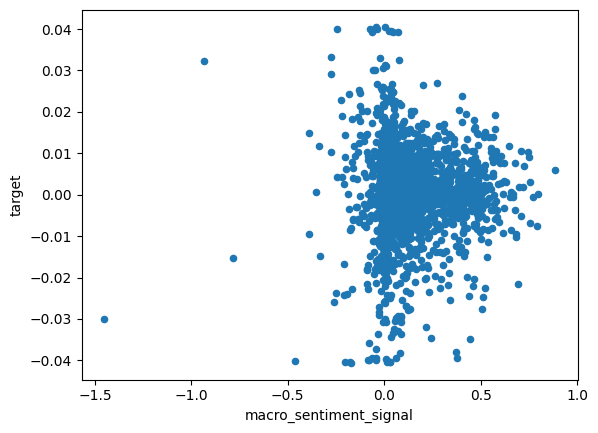

In [ ]:
train[['date_id', 'target', 'macro_sentiment_signal']].to_pandas().plot(kind = 'scatter', x ='macro_sentiment_signal', y = 'target')

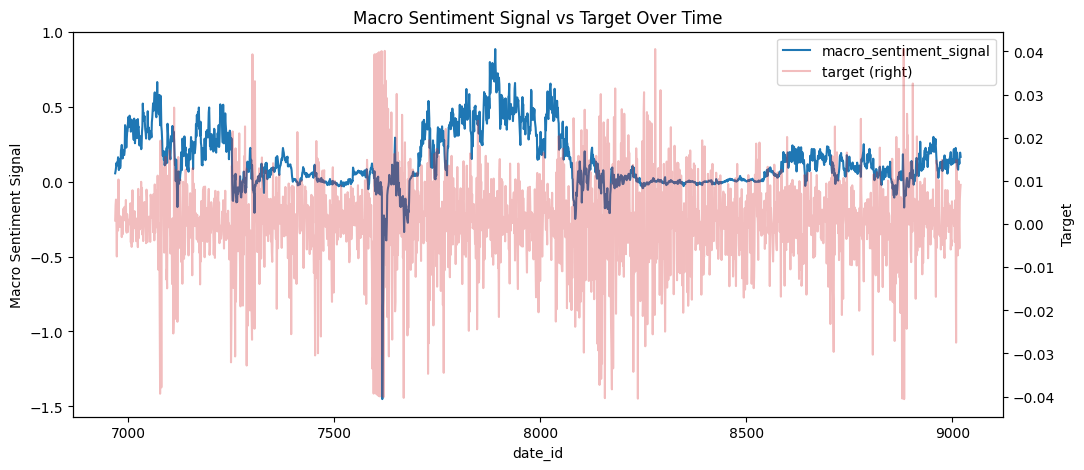

In [ ]:
plot_data = train[['date_id', 'target', 'macro_sentiment_signal']].to_pandas()

ax = plot_data.plot(
    x='date_id',
    y='macro_sentiment_signal',
    figsize=(12, 5),
    label='macro_sentiment_signal',
    color='tab:blue'
)

# Secondary axis for `target`
plot_data.plot(
    x='date_id',
    y='target',
    ax=ax,
    secondary_y=True,
    label='target',
    color='tab:red',
    alpha = 0.3
)

ax.set_ylabel("Macro Sentiment Signal")
ax.right_ax.set_ylabel("Target")
plt.title("Macro Sentiment Signal vs Target Over Time")
plt.show()

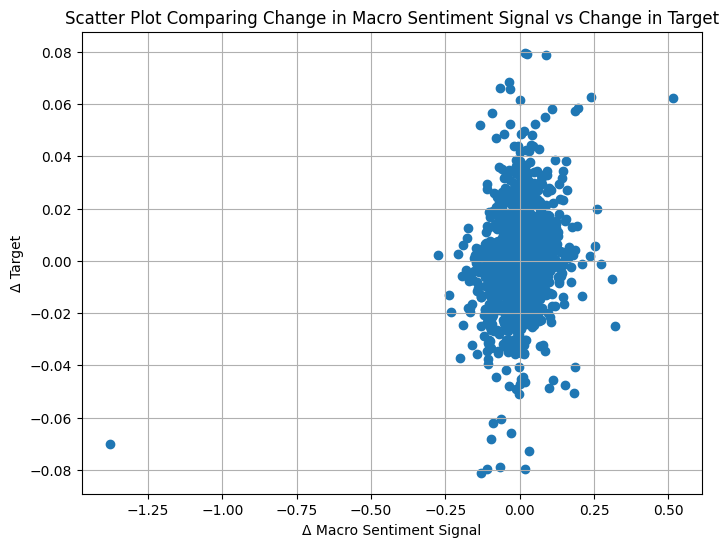

In [ ]:
# Prepare data (no overwriting your existing df)
plot_data = train[['date_id', 'target', 'macro_sentiment_signal']].to_pandas().copy()

# Compute change (first difference)
plot_data['delta_target'] = plot_data['target'].diff()
plot_data['delta_macro'] = plot_data['macro_sentiment_signal'].diff()

# Drop the first row with NaNs
plot_data = plot_data.dropna()

# Scatter plot: change vs change
plt.figure(figsize=(8, 6))
plt.scatter(plot_data['delta_macro'], plot_data['delta_target'])
plt.xlabel("Δ Macro Sentiment Signal")
plt.ylabel("Δ Target")
plt.title("Scatter Plot Comparing Change in Macro Sentiment Signal vs Change in Target")
plt.grid(True)
plt.show()

## Save to Github

In [ ]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "Hull_Tactical_Market_Prediction"
username = "abishpius"
message = "Kaggle Competition Hull_Tactical_Market_Prediction"
notebook_name = "Hull_Tactical.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"
        readme_text = ""
        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'Hull_Tactical_Market_Prediction' already exists at: https://github.com/abishpius/Hull_Tactical_Market_Prediction


In [ ]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "hbgb feature selection final"
!git push

Cloning into 'Hull_Tactical_Market_Prediction'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 57 (delta 15), reused 51 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 2.63 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/Hull_Tactical_Market_Prediction
[main 503b439] hbgb feature selection final
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Hull_Tactical.ipynb (78%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 114.15 KiB | 671.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/abishpius/Hull_Tactical_Market_Prediction.git
   4cfd317..503b439  main -> main
